### Nandini `MDS202335`
### Aritra `MCS202304`

### Importing necessary modules and suppressing warnings

In [85]:
import math
import random
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import optim
import torch.nn as nn
import torch.optim as oweptim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings

warnings.filterwarnings('ignore')

# Define training and testing set

In [86]:
TRAIN_PATH = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
TEST_PATH = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"

In [87]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Define `utility` function

In [88]:
transform = transforms.Compose([transforms.ToTensor()])

def convert_row_to_image_label(row):
    """
    Takes a row and assigns the first column as label and convert the remaining 784 columns to image tensor
    """
    label = row[0]
    pixels = row[1:].values.reshape(28, 28).astype(np.uint8)
    image = Image.fromarray(pixels, mode='L')
    image_tensor = transform(image)
    return image_tensor, label

# Define `dataloader`

For each of the labels, we are creating a dataloader.

We will define a GAN which consists of 10 `generators` and 10 `discriminators`. Each pair will be trained for each of the 10 type of fashion objects.

In [89]:
train_dfs = [train[train["label"] == i] for i in range(10)]

train_ds = [[convert_row_to_image_label(row) for _, row in df.iterrows()] for df in train_dfs]

In [90]:
dl = [DataLoader(dataset=ds, shuffle=True, batch_size=64) for ds in train_ds]

# Define the mapping between `classes` and `labels`

In [91]:
fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [92]:
fashion_mnist_indices = {
    "T-shirt": 0,
    "Trouser": 1,
    "Pullover": 2,
    "Dress": 3,
    "Coat": 4,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 7,
    "Bag": 8,
    "Ankle boot": 9
}


# Define a utility function to print batch of images

T-shirt/top


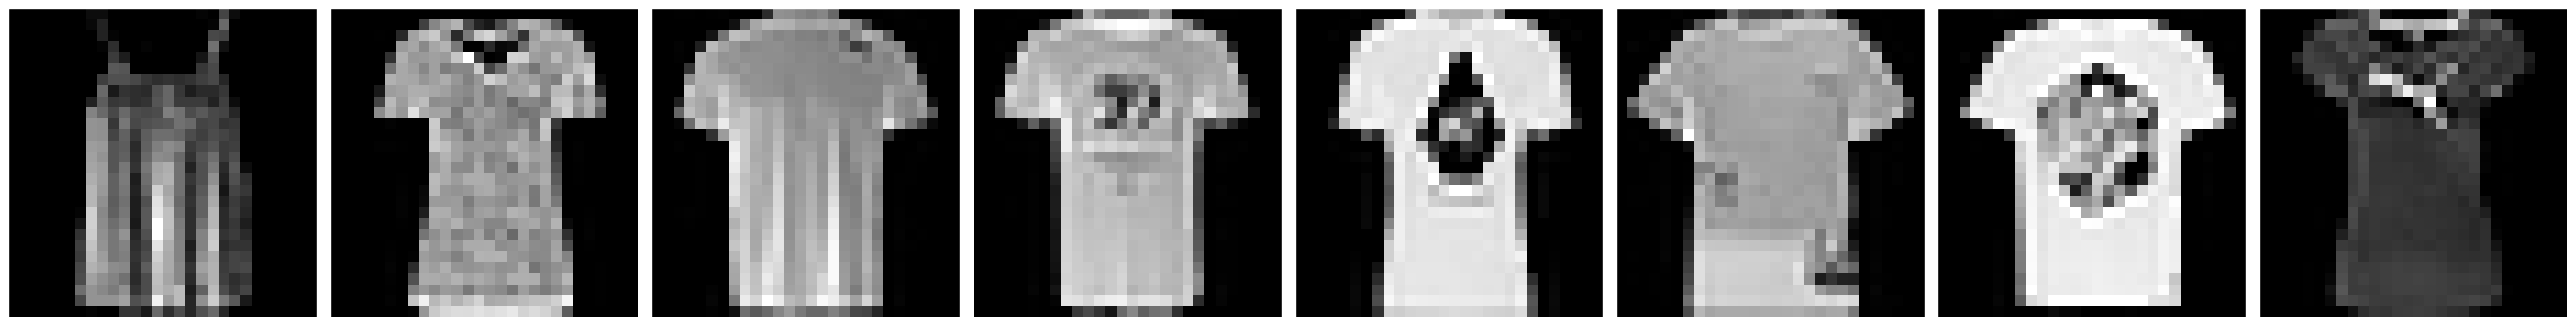

Trouser


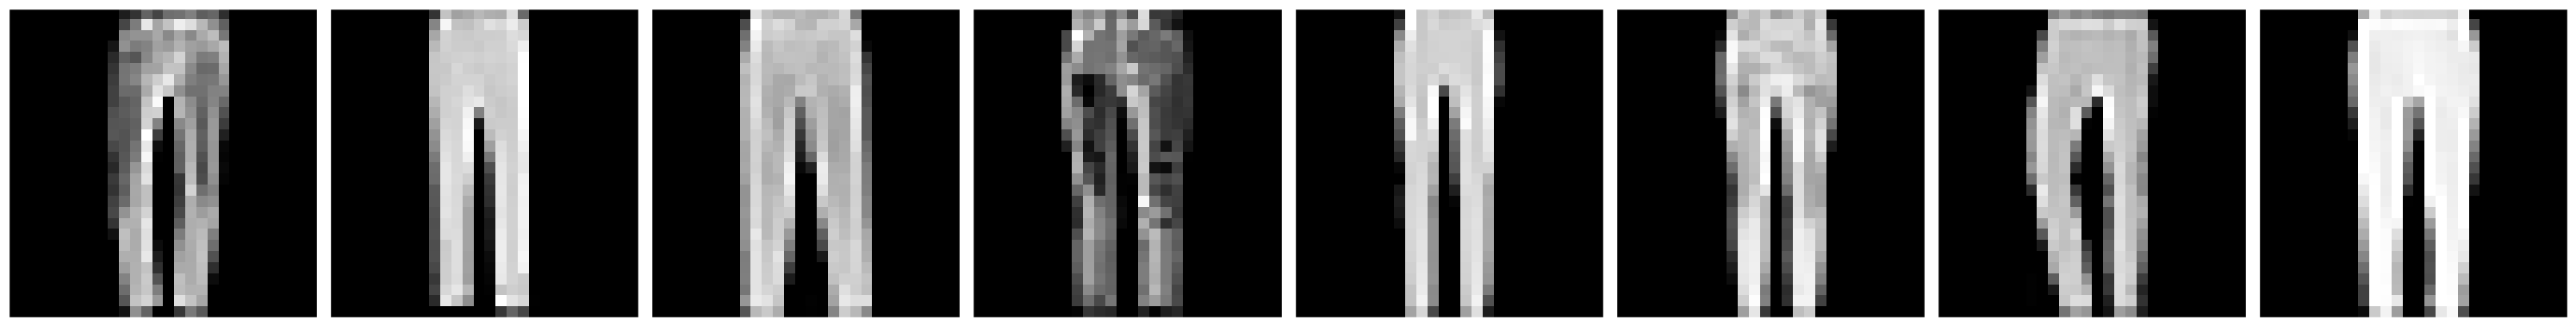

Pullover


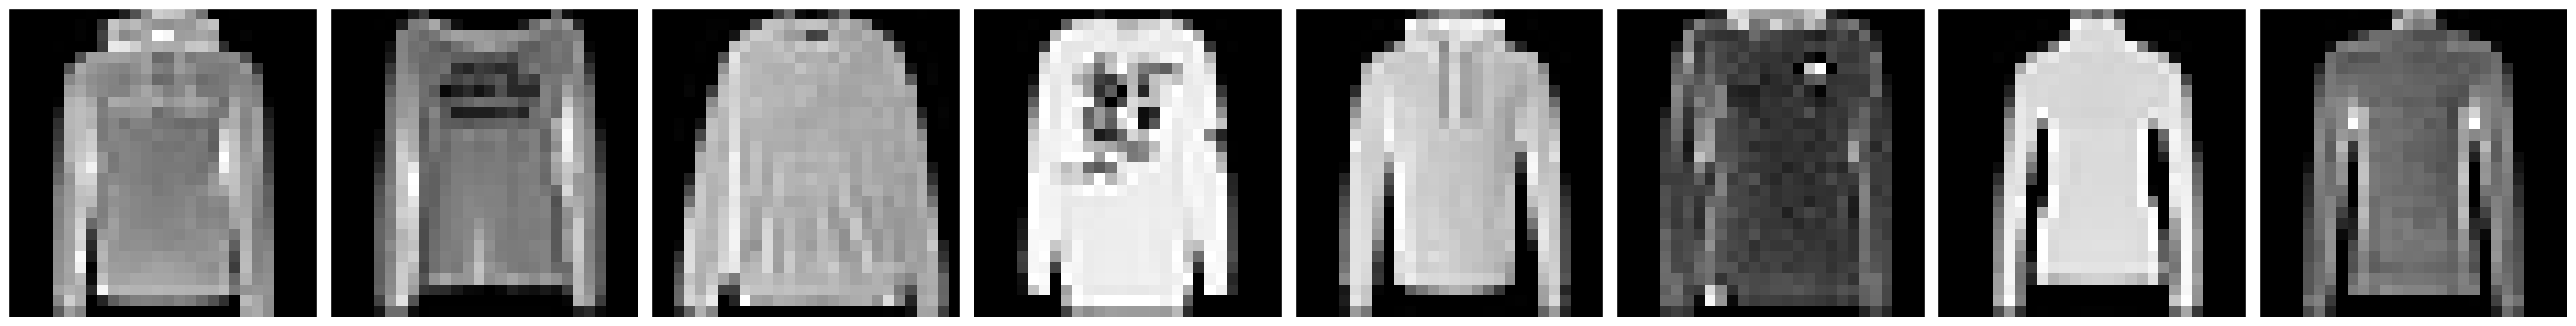

Dress


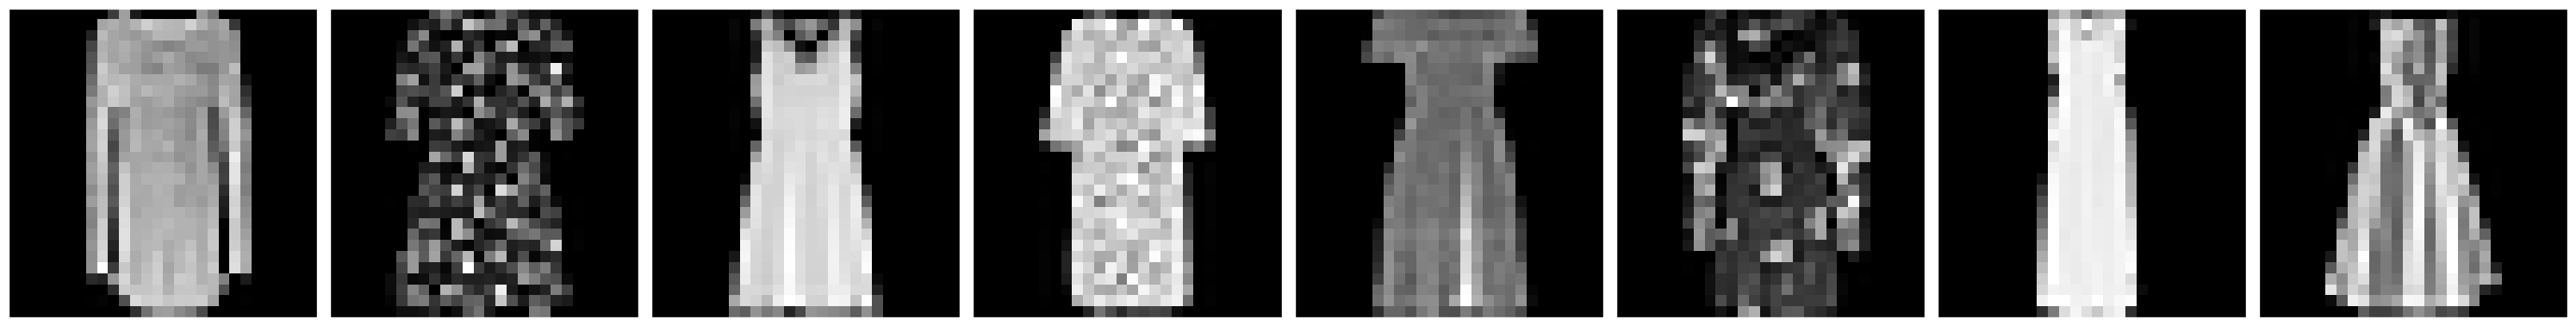

Coat


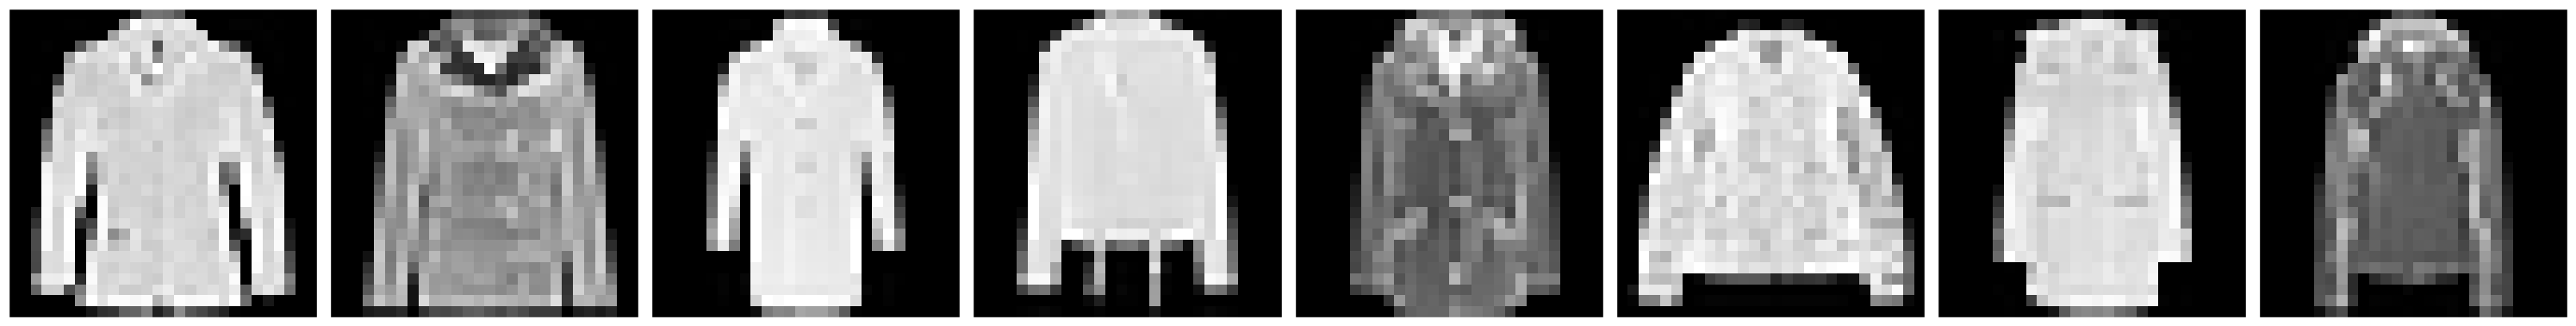

Sandal


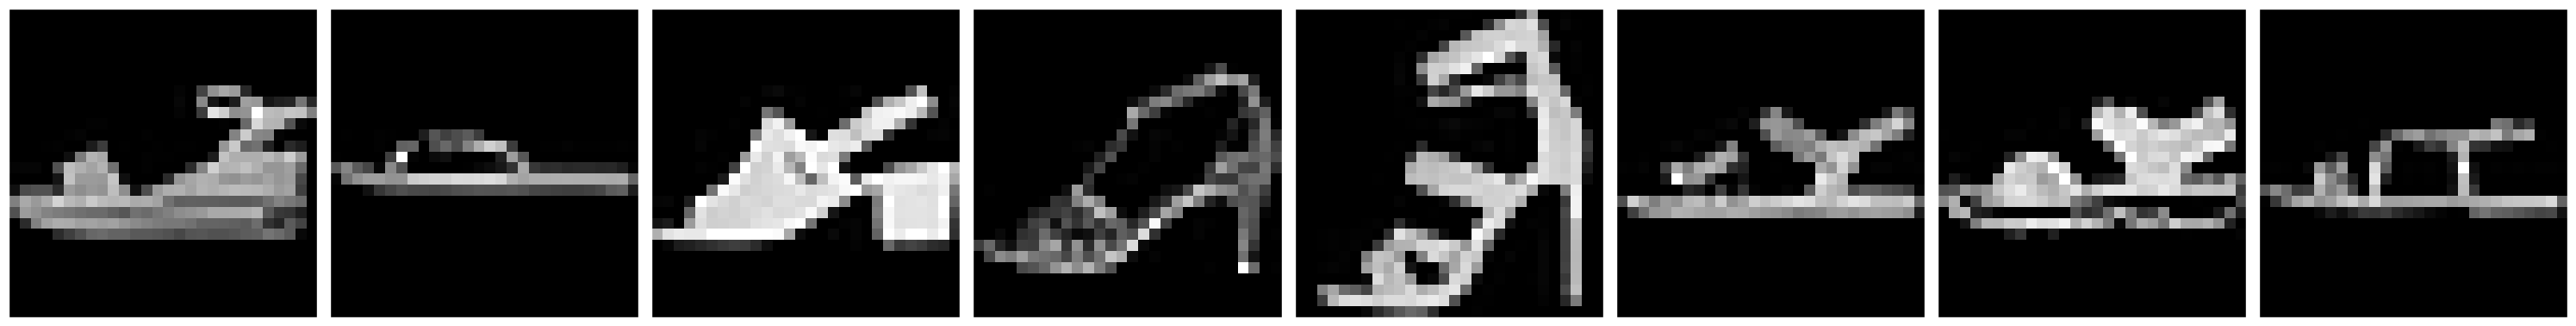

Shirt


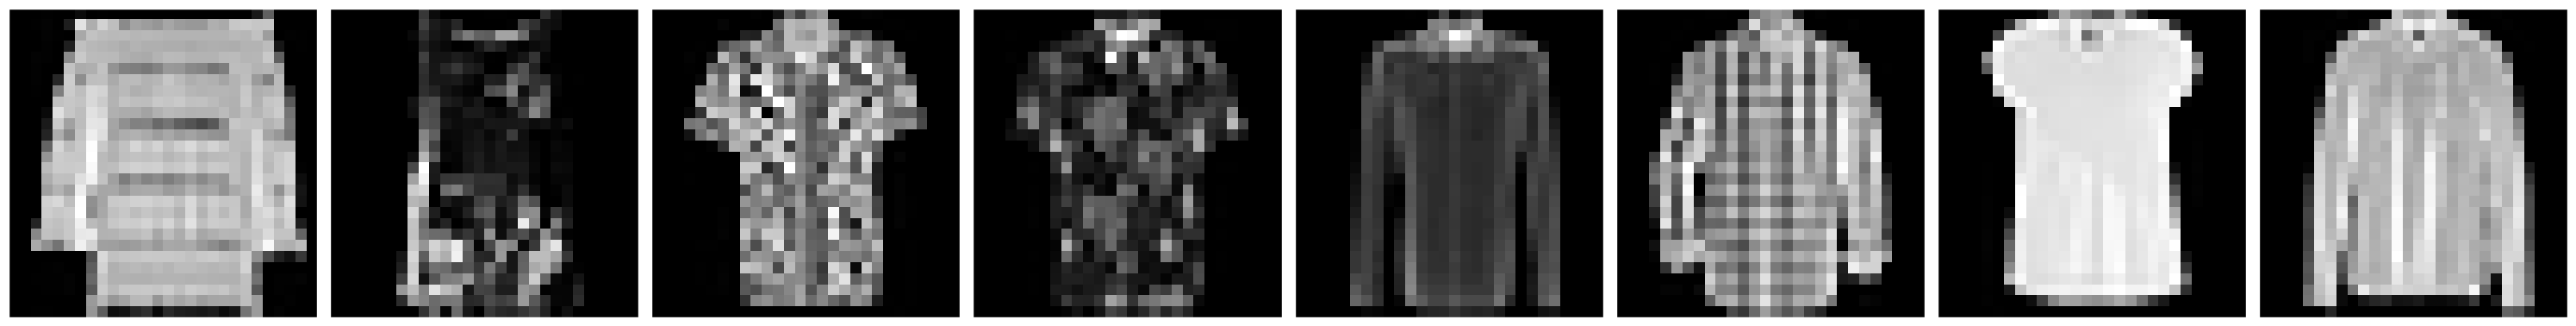

Sneaker


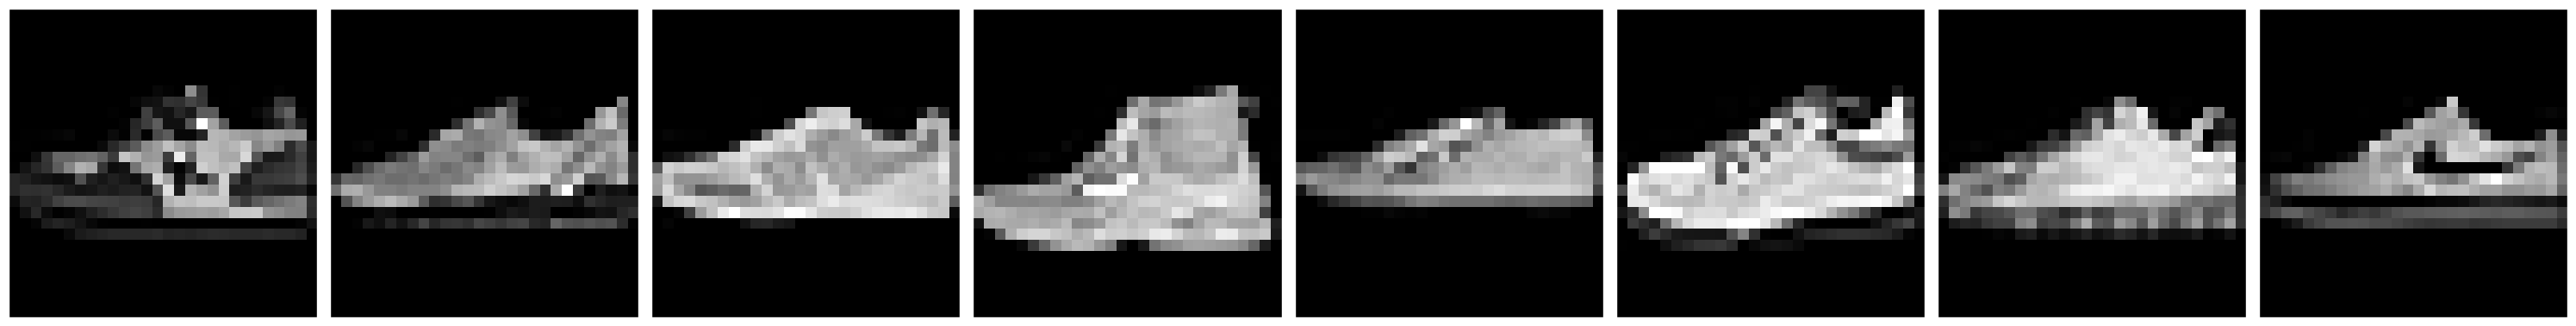

Bag


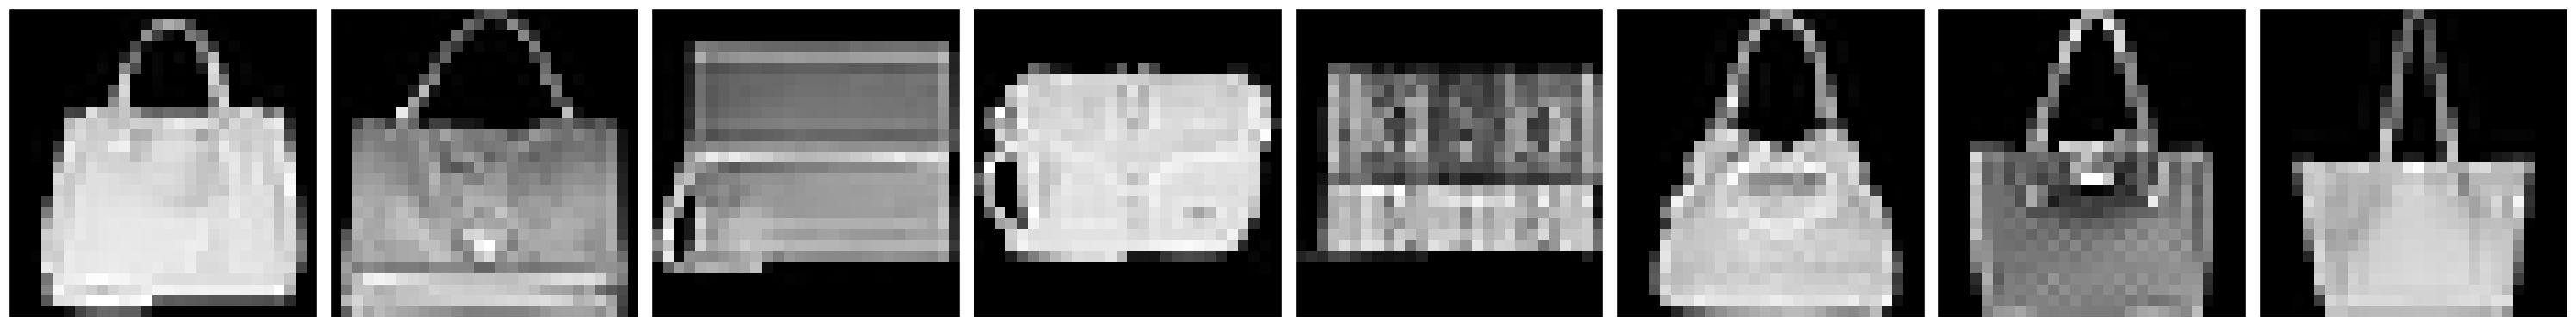

Ankle boot


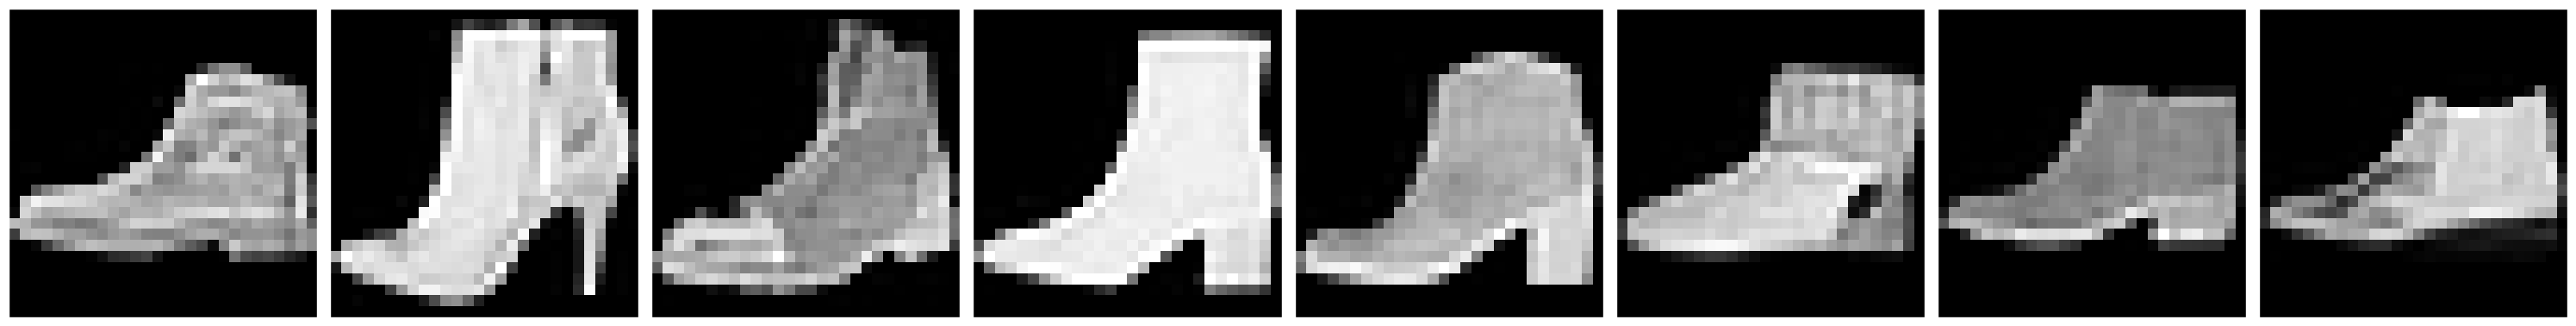

In [93]:
def display_images(images, n_cols=4, figsize=(30, 15), labels=None):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
    labels: int[]
            array of the labels for the batch
            
    Returns
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        image = image.permute(1, 2, 0)
        cmap = 'gray' if image.shape[2] == 1 else plt.cm.viridis
        ax.imshow(image, cmap=cmap)
        
        if labels is not None:
            ax.set_title(str(labels[idx]), fontsize=10)
        
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()

for i in range(10):
    image_batch = next(iter(dl[i]))
    print(fashion_mnist_labels[i])
    display_images(images=image_batch[0][:8], n_cols=8)

# Discriminator Architecture

## Layer Structure

| Layer | Type | Input Size | Output Size | Activation | Dropout |
|-------|------|------------|-------------|------------|----------|
| 1 | Linear | in_features | 128 | LeakyReLU(0.2) | 0.3 |
| 2 | Linear | 128 | 64 | LeakyReLU(0.2) | 0.3 |
| 3 | Linear | 64 | 32 | LeakyReLU(0.2) | 0.3 |
| 4 | Linear | 32 | out_features | None | None |

## Network Features
- **Input Shape**: (batch_size, in_features)
- **Output Shape**: (batch_size, out_features)
- **Total Layers**: 4 fully connected layers
- **Activation**: LeakyReLU with negative_slope=0.2
- **Regularization**: Dropout with p=0.3 after each hidden layer
- **Architecture Pattern**: Progressive downsampling (in_features → 128 → 64 → 32 → out_features)

## Data Flow
```plaintext
Input → FC1(→128) → LeakyReLU → Dropout 
     → FC2(→64)  → LeakyReLU → Dropout 
     → FC3(→32)  → LeakyReLU → Dropout 
     → FC4(→out) → Output
```

In [35]:
class Discriminator(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.fc1 = nn.Linear(in_features=in_features, out_features=128)
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.leaky_relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=32, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.leaky_relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu2(x)
        x = self.dropout(x)                        
        x = self.fc3(x)
        x = self.leaky_relu3(x)        
        x = self.dropout(x)
        logit_out = self.fc4(x)
        
        return logit_out

# Generator Architecture

## Layer Structure
| Layer | Type | Input Size | Output Size | Activation | Dropout |
|-------|------|------------|-------------|------------|----------|
| 1 | Linear | in_features | 32 | LeakyReLU(0.2) | 0.3 |
| 2 | Linear | 32 | 64 | LeakyReLU(0.2) | 0.3 |
| 3 | Linear | 64 | 128 | LeakyReLU(0.2) | 0.3 |
| 4 | Linear | 128 | out_features | Tanh | None |

## Network Features
- **Input Shape**: (batch_size, in_features)
- **Output Shape**: (batch_size, out_features)
- **Total Layers**: 4 fully connected layers
- **Hidden Activation**: LeakyReLU with negative_slope=0.2
- **Output Activation**: Tanh
- **Regularization**: Dropout with p=0.3 after each hidden layer
- **Architecture Pattern**: Progressive upsampling (in_features → 32 → 64 → 128 → out_features)

## Data Flow
```plaintext
Input → FC1(→32)  → LeakyReLU → Dropout 
     → FC2(→64)  → LeakyReLU → Dropout 
     → FC3(→128) → LeakyReLU → Dropout 
     → FC4(→out) → Tanh     → Output
```

<details>

<summary>Note</summary>

This generator is essentially a mirror of the discriminator, but with reversed dimensionality (expanding instead of contracting) and a Tanh activation at the output instead of raw logits.

</details>

In [36]:
class Generator(nn.Module):
    def __init__(self, in_features, out_features):
        super(Generator, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc1 = nn.Linear(in_features=in_features, out_features=32)
        self.relu1 = nn.LeakyReLU(negative_slope=0.2)
        self.fc2 = nn.Linear(in_features=32, out_features=64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc3 = nn.Linear(in_features=64, out_features=128)
        self.relu3 = nn.LeakyReLU(negative_slope=0.2)        
        self.fc4 = nn.Linear(in_features=128, out_features=out_features)
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)        
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)        
        x = self.dropout(x)
        x = self.fc4(x)
        tanh_out = self.tanh(x)
        
        return tanh_out

# Defining loss functions
- real loss: denotes the loss when provided images are real.
```python
targets = torch.ones(batch_size).to(device)
```
- fake loss: denotes the loss when provided images are fake.
```python
targets = torch.zeros(batch_size).to(device)
```

In [37]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

# Store images for some epochs

In [38]:
gan_output_samples = [None]*10

# Training Function for MNIST GAN

The `train_mnist_gan` function is responsible for training a Generative Adversarial Network (GAN) using a Discriminator and a Generator model on the MNIST dataset. The function optimizes both models using their respective loss functions and optimizers.

### Parameters
- **`discriminator`**: The discriminator model that distinguishes between real and fake images.
- **`generator`**: The generator model that creates fake images from random noise.
- **`d_optim`**: The optimizer for the discriminator.
- **`g_optim`**: The optimizer for the generator.
- **`loss_fn`**: The loss function used to compute the losses for both models.
- **`dl`**: The data loader providing batches of real images from the MNIST dataset.
- **`n_epochs`**: The number of epochs for training.
- **`label`**: A label used to store generated samples.
- **`device`**: The device to which the models and tensors should be moved (e.g., CPU or GPU).

## Initialization

- **Latent Space Size**: The size of the random noise vector `z` is set to 100.
- **Fixed Noise**: A fixed noise vector `fixed_z` is generated to visualize the generator's output during training.
- **Loss Tracking**: Two lists, `d_losses` and `g_losses`, are initialized to keep track of discriminator and generator losses respectively.


### Batch Loop

For each batch of real images:
1. **Move Real Images to Device**: Real images are transferred to the specified device.
2. **Discriminator Training**:
    - **Zero Gradients**: The gradients for the discriminator optimizer are reset.
    - **Normalize Real Images**: Real images are scaled from [0, 1] to [-1, 1].
    - **Calculate Real Loss**: The discriminator outputs logits for real images, and the loss is calculated.
   
3. **Generate Fake Images**:
    - **Noise Sampling**: Random noise `z` is generated.
    - **Generate Fake Images**: The generator produces fake images using the noise.
    - **Calculate Fake Loss**: The discriminator outputs logits for fake images, and the loss is calculated.

4. **Backpropagation**:
    - **Total Discriminator Loss**: The total discriminator loss is calculated and backpropagated.
    - **Optimizer Step**: The discriminator optimizer updates the weights.

5. **Generator Training**:
    - **Zero Gradients**: The gradients for the generator optimizer are reset.
    - **Generate Fake Images**: Random noise `z` is generated again.
    - **Discriminator Logits**: The discriminator outputs logits for the newly generated fake images.
    - **Calculate Generator Loss**: The generator's loss is calculated based on the discriminator's logits.
    - **Backpropagation**: The generator loss is backpropagated and the optimizer updates the weights.

### Generating Samples

At the end of each epoch, the generator is set to evaluation mode, and the generated samples from the fixed noise `fixed_z` are stored for visualization later.

The function returns the lists of discriminator and generator losses over the epochs

In [74]:
def train_mnist_gan(discriminator, generator, d_optim, g_optim, loss_fn, dl, n_epochs, label, device):
    """
    Train a Generative Adversarial Network (GAN) on the Fashion MNIST dataset.

    Parameters
    discriminator: nn.Module
        The discriminator model used to differentiate between real and fake images.
    
    generator: nn.Module
        The generator model that creates fake images from random noise.
    
    d_optim: torch.optim.Optimizer
        The optimizer for updating the discriminator's weights.
    
    g_optim: torch.optim.Optimizer
        The optimizer for updating the generator's weights.
    
    loss_fn: callable
        The loss function used for training the models, typically binary cross-entropy.
    
    dl: DataLoader
        The DataLoader providing the training dataset.
    
    n_epochs: int
        The number of training epochs to run.
    
    label: int
        The label of the class being trained (0-9 for Fashion MNIST).
    
    device: str
        The device to run the training on ('cuda' for GPU or 'cpu').
    
    Returns
    d_losses: list
        A list containing the discriminator's loss for each epoch.
    
    g_losses: list
        A list containing the generator's loss for each epoch.
    """
    z_size = 100
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    discriminator = discriminator.to(device)
    generator = generator.to(device)
    
    for epoch in range(n_epochs):
        discriminator.train()
        generator.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            real_images = real_images.to(device)
            
           
            d_optim.zero_grad()
            
            
            real_images = (real_images * 2) - 1  
            d_real_logits_out = discriminator(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            
            with torch.no_grad():
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                fake_images = generator(z) 
            d_fake_logits_out = discriminator(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optim.step()
            d_running_batch_loss += d_loss
            
            g_optim.zero_grad()
            
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            fake_images = generator(z) 
            g_logits_out = discriminator(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            g_loss.backward()
            g_optim.step()
            g_running_batch_loss += g_loss
            
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        if((epoch - 19) % 20 == 0):
            print(f'Epoch [{epoch+1}/{n_epochs}]:')
            print(f'discriminator loss: {d_epoch_loss:.6f} \tgenerator loss: {g_epoch_loss:.6f}')
        
        generator.eval()
        fixed_samples.append(generator(fixed_z).detach().cpu())
    
    gan_output_samples[label] = fixed_samples
     
    return d_losses, g_losses

# Training the `GAN` for `Fashion MNIST`

The GAN has 10 generators and 10 discriminators, each pair curated for one of 10 classes.

As, we will need labeled images, the intuition is to create 10 such networks as they are completely uncorrelated.

In [100]:
discriminators = [Discriminator(in_features=784, out_features=1) for _ in range(10)]
generators = [Generator(in_features=100, out_features=784) for _ in range(10)]

d_optims = [optim.Adam(d.parameters(), lr=0.001) for d in discriminators]
g_optims = [optim.Adam(g.parameters(), lr=0.001) for g in generators]

loss_fns = [nn.BCEWithLogitsLoss() for i in range(10)]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_epochs = 100
d_losses = [None] * 10
g_losses = [None] * 10
for i in range(10):
    print(f"Training GAN for {fashion_mnist_labels[i]} on {device}")
    d_losses[i], g_losses[i] = train_mnist_gan(discriminators[i], generators[i], d_optims[i], g_optims[i], loss_fns[i], dl[i], n_epochs, i, device)
    
with open('gan_output_samples.pkl', 'wb') as f:
    pkl.dump(gan_output_samples, f)

Training GAN for T-shirt/top on cuda
Epoch [20/100]:
discriminator loss: 0.837518 	generator loss: 1.970007
Epoch [40/100]:
discriminator loss: 0.982235 	generator loss: 1.360531
Epoch [60/100]:
discriminator loss: 1.257984 	generator loss: 0.972454
Epoch [80/100]:
discriminator loss: 1.244667 	generator loss: 0.995805
Epoch [100/100]:
discriminator loss: 1.278474 	generator loss: 0.988619
Training GAN for Trouser on cuda
Epoch [20/100]:
discriminator loss: 0.430796 	generator loss: 2.546812
Epoch [40/100]:
discriminator loss: 1.146450 	generator loss: 1.134238
Epoch [60/100]:
discriminator loss: 1.183538 	generator loss: 1.018697
Epoch [80/100]:
discriminator loss: 1.128612 	generator loss: 1.217513
Epoch [100/100]:
discriminator loss: 1.305847 	generator loss: 0.852213
Training GAN for Pullover on cuda
Epoch [20/100]:
discriminator loss: 0.777381 	generator loss: 2.314518
Epoch [40/100]:
discriminator loss: 1.129567 	generator loss: 1.239487
Epoch [60/100]:
discriminator loss: 1.0938

## Plot the losses of each pair of `generator` and `discriminator`

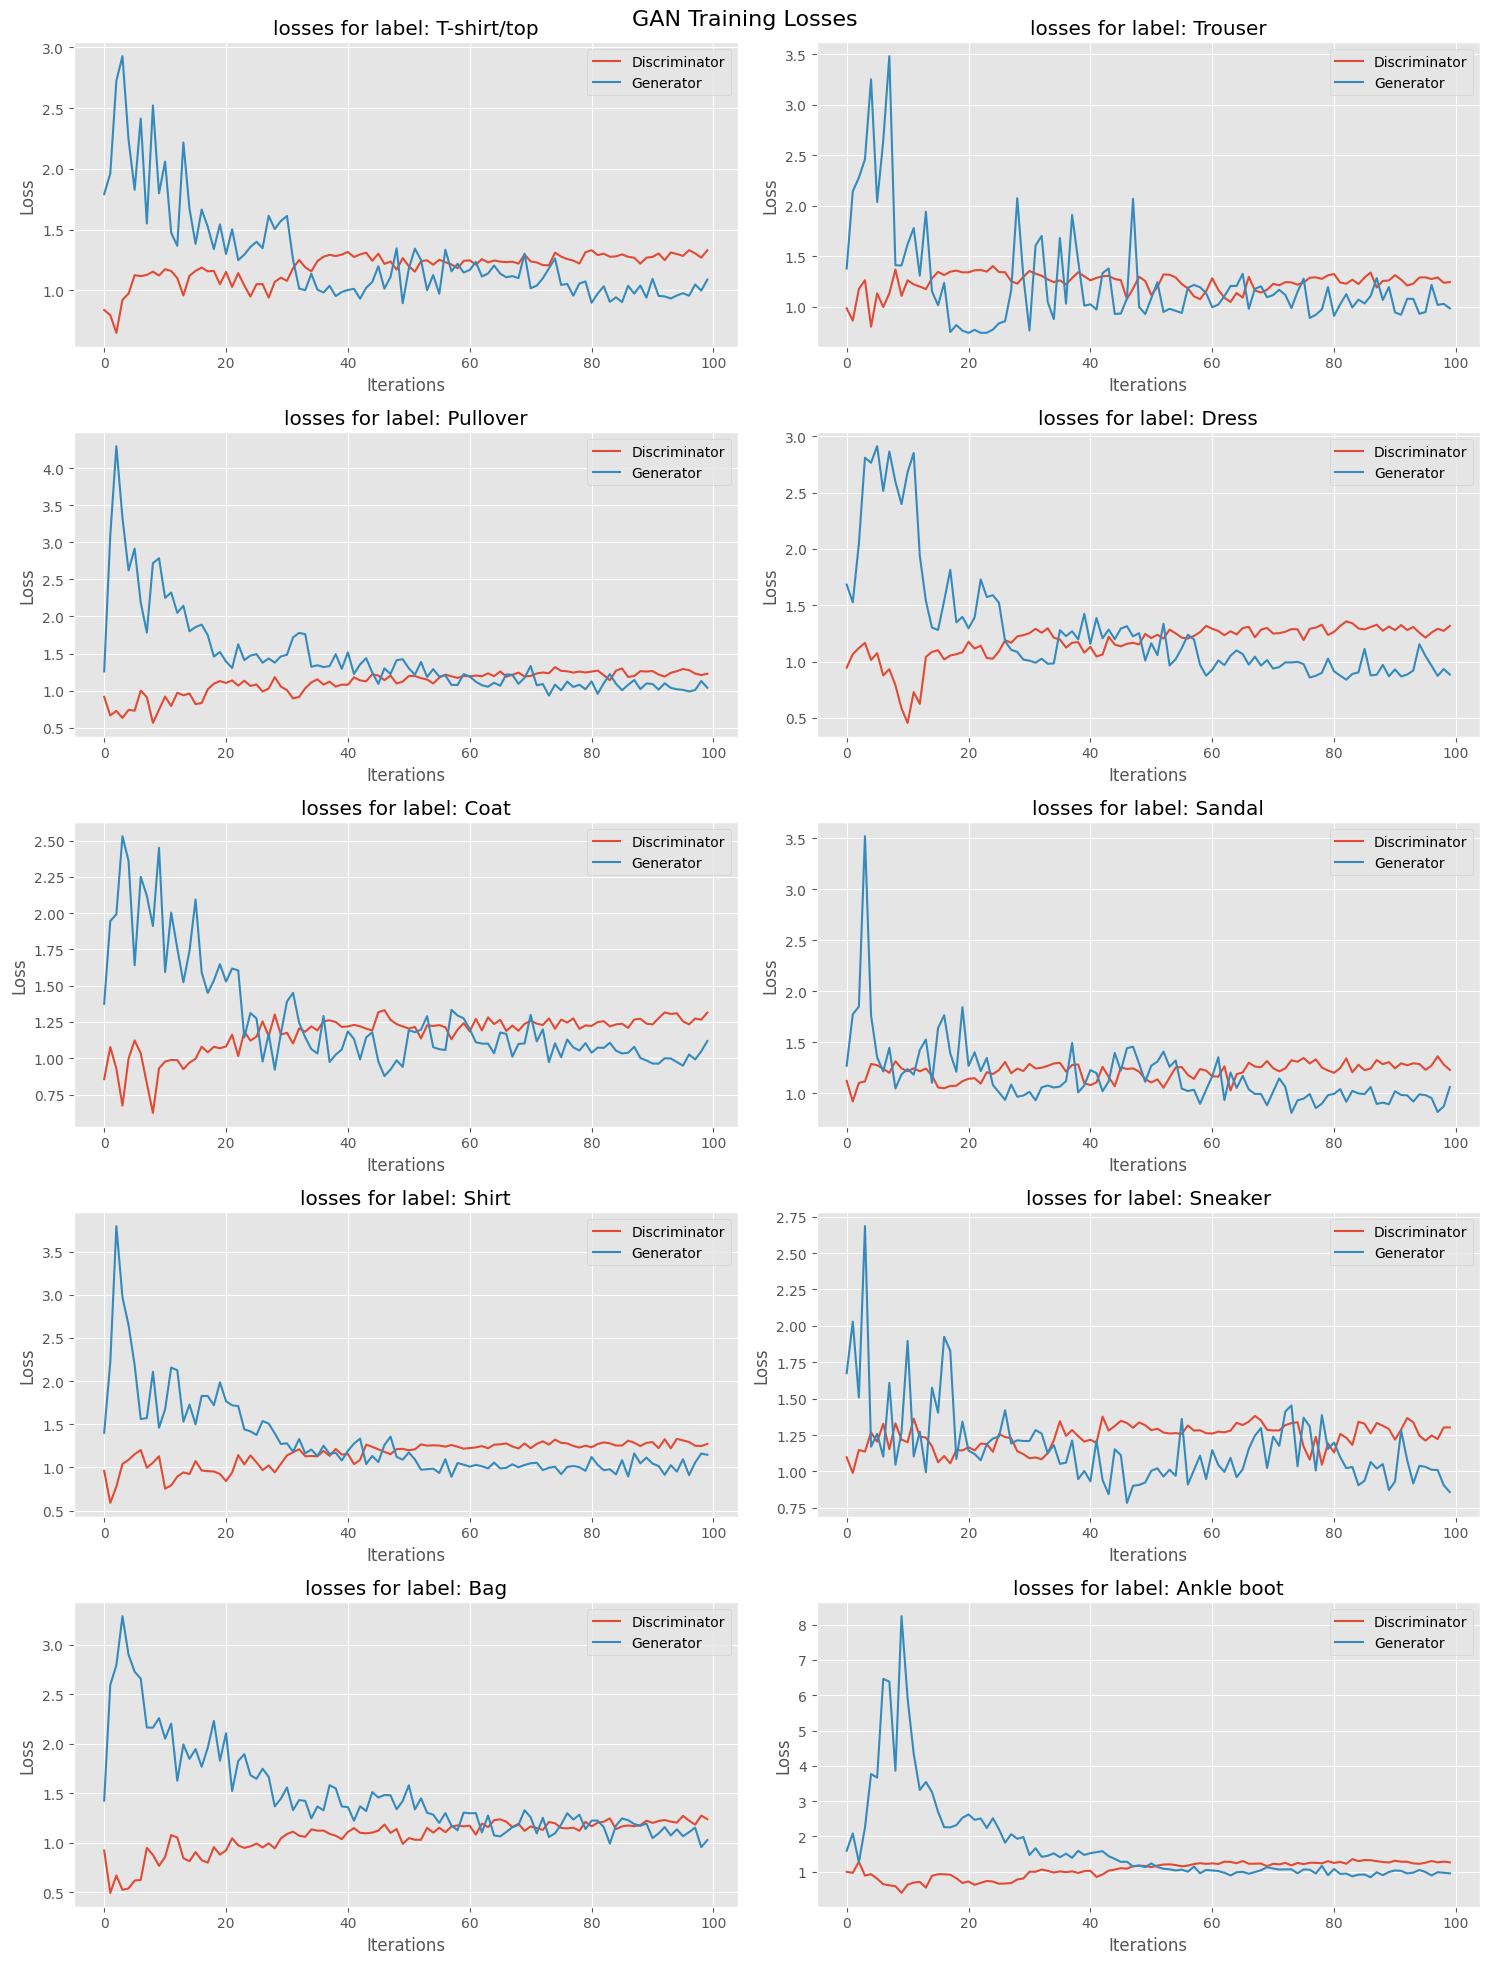

In [109]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('GAN Training Losses', fontsize=16)

axes = axes.flatten()

for i in range(10):
    axes[i].plot(d_losses[i], label='Discriminator')
    axes[i].plot(g_losses[i], label='Generator')
    axes[i].legend()
    axes[i].set_title(f'losses for label: {fashion_mnist_labels[i]}')
    axes[i].set_xlabel('Iterations')
    axes[i].set_ylabel('Loss')
    
plt.tight_layout()
plt.show()

# Print images over epochs to show improvement of the `generator`

In [111]:
def show_gan_generated_images(label, n_cols=8):
    """
    Display generated images from a trained GAN for a specific label at different training epochs.
    
    Parameters
    label: int
        The label corresponding to the class of images generated by the GAN (0-9 for Fashion MNIST).
    
    n_cols: int, optional
        The number of columns in the image grid (default is 8).
        
    Returns
    None
        Displays the generated images in a grid format using the `display_images` function.
    """
    with open('gan_output_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)
    sample_images = []
    sample_labels = []
    for epoch in [1, 5, 10, 20, 30, 50, 75, 100]:
        epoch_data = saved_data[label][epoch-1]
        epoch_data = (epoch_data + 1) / 2
        batch_size, channel, height, width = len(epoch_data), 1, 28, 28
        image_batch = epoch_data.view(batch_size, channel, height, width)
        random_index = random.randint(0, batch_size - 1)  # Generates a random index in the range [0, batch_size-1]
        sample_images.append(image_batch[random_index])
        sample_labels.append(f"After epoch {epoch}")
        
    display_images(images=sample_images, n_cols=n_cols, figsize=(12, 4), labels=sample_labels)

Generator for T-shirt/top


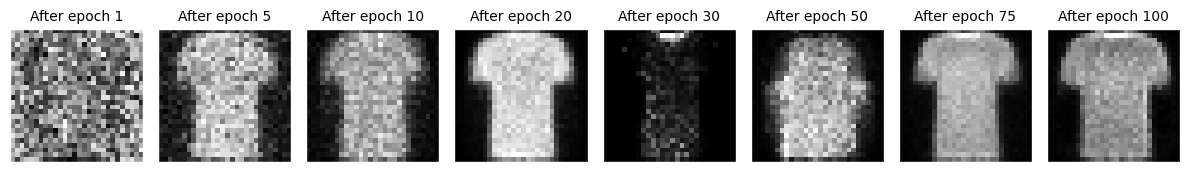

Generator for Trouser


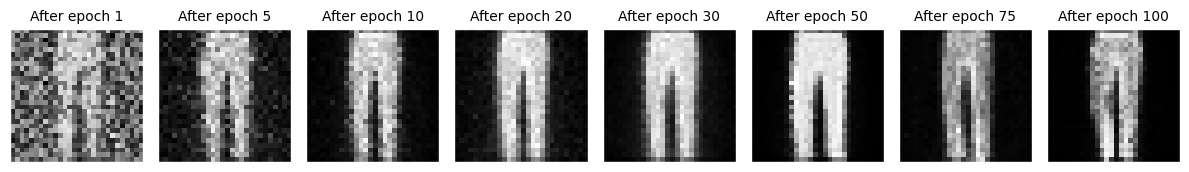

Generator for Pullover


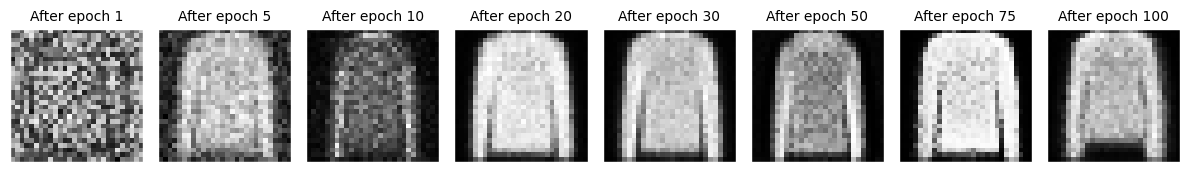

Generator for Dress


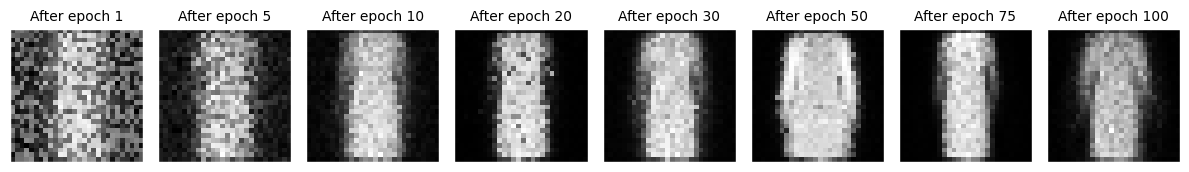

Generator for Coat


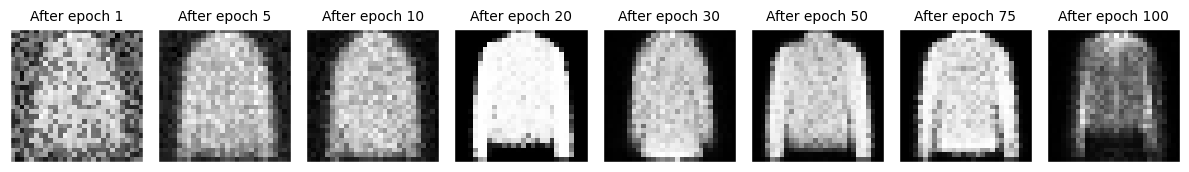

Generator for Sandal


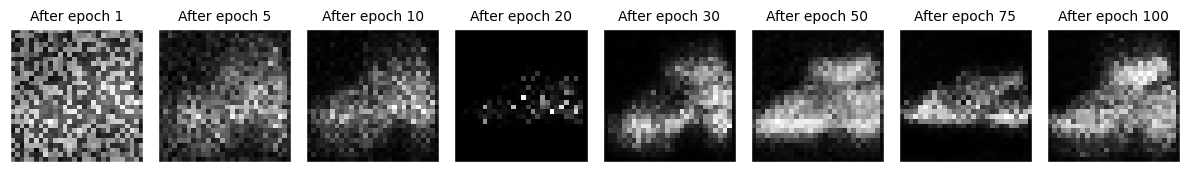

Generator for Shirt


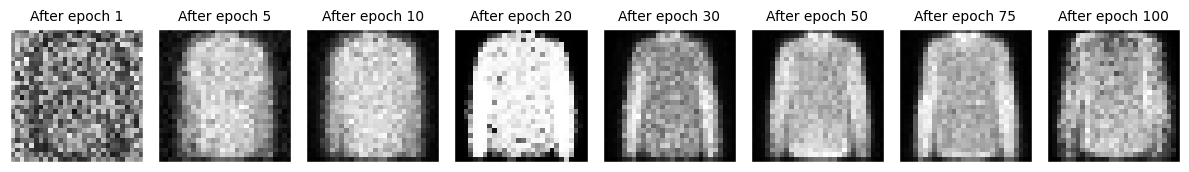

Generator for Sneaker


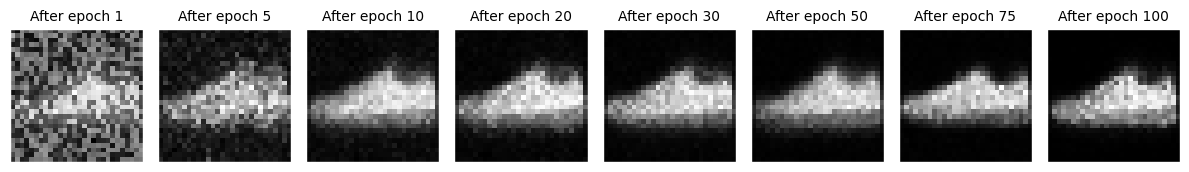

Generator for Bag


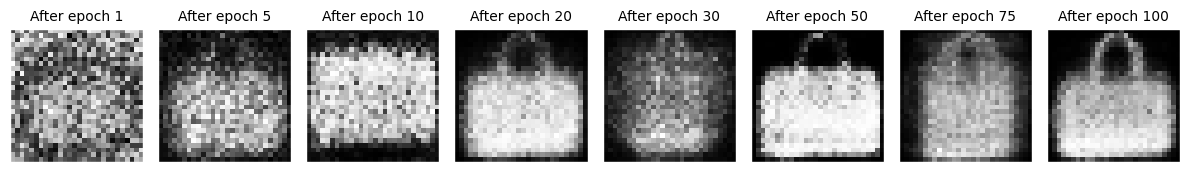

Generator for Ankle boot


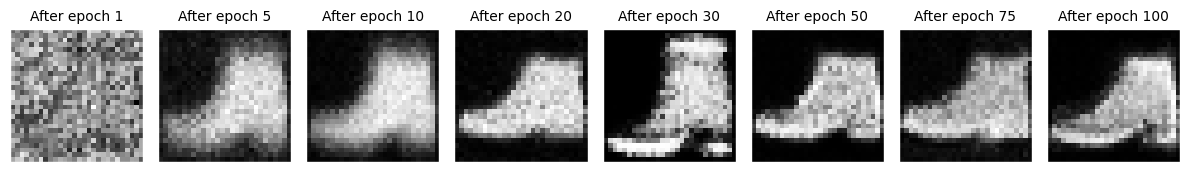

In [112]:
for label in range(10):
    print(f"Generator for {fashion_mnist_labels[label]}")
    show_gan_generated_images(label, n_cols=8)

# The function `generate(label, z)`
on a label, and a random codeword, generates an image of that label

In [66]:
def generate(label, z = np.random.uniform(-1, 1, size=(1, 100))):
    """
    Generate a fake image using the specified generator for the given label.

    Parameters
    label: int or str
        The label for which to generate a fake image. If a string is provided, it should correspond to a key in the 
        `fashion_mnist_labels` dictionary. If an integer is provided, it should be in the range 0-9, representing 
        the class of the Fashion MNIST dataset.
    
    z:  
        A randomm codeword from latent space

    Returns
    None
    """
    if not isinstance(label, int):
        label = fashion_mnist_indices[label]
    generators[label].to('cpu')
    generators[label].eval()
    z = torch.from_numpy(z).float()
    fake_image = generators[label](z)
    fake_image = fake_image.view(1, 1, 28, 28).detach()
    print(f"{fashion_mnist_labels[label]}")
    display_images(fake_image, n_cols=1, figsize=(2, 2))

T-shirt/top


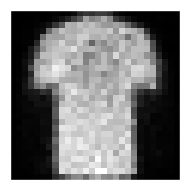

In [113]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("T-shirt", z)

Ankle boot


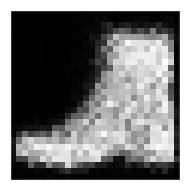

In [132]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Ankle boot", z)

Dress


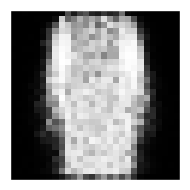

In [114]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Dress", z)

Sneaker


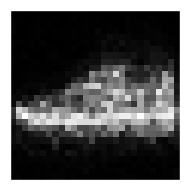

In [140]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Sneaker", z)

Sandal


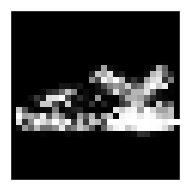

In [109]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Sandal", z)

Sandal


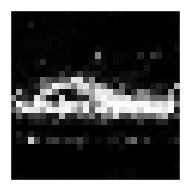

In [115]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Sandal", z)

Bag


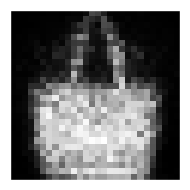

In [97]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Bag")

Bag


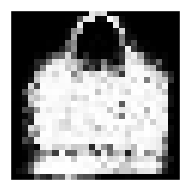

In [153]:
z = np.random.uniform(-1, 1, size=(1, 100))
generate("Bag")

# Print 8 `randomly generated images` from each class

In [ ]:
def generate_fake_images(label_index):
    """
    Generate and display 8 fake images for a single specified label in the Fashion MNIST dataset.

    This function creates a row of images for a specific label from the Fashion MNIST dataset, 
    containing 8 generated images for that label.

    Parameters:
    label_index: int
                 Index of the label to generate images for (0 to 9 for Fashion MNIST).
    
    Returns:
    None
    """
    n_images_per_label = 8
    
    fig, axs = plt.subplots(1, n_images_per_label, figsize=(30, 4))
    
    generators[label_index].to('cpu')
    generators[label_index].eval()
    
    for img_idx in range(n_images_per_label):
        z = np.random.uniform(-1, 1, size=(1, 100))
        z = torch.from_numpy(z).float()
        
        fake_image = generators[label_index](z)
        fake_image = fake_image.view(1, 1, 28, 28).detach()
        
        ax = axs[img_idx]
        image = fake_image.permute(0, 2, 3, 1).squeeze()
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
    axs[0].set_title(f'{fashion_mnist_labels[label_index]}', loc='left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Round 1

Generate images for T-shirt/top


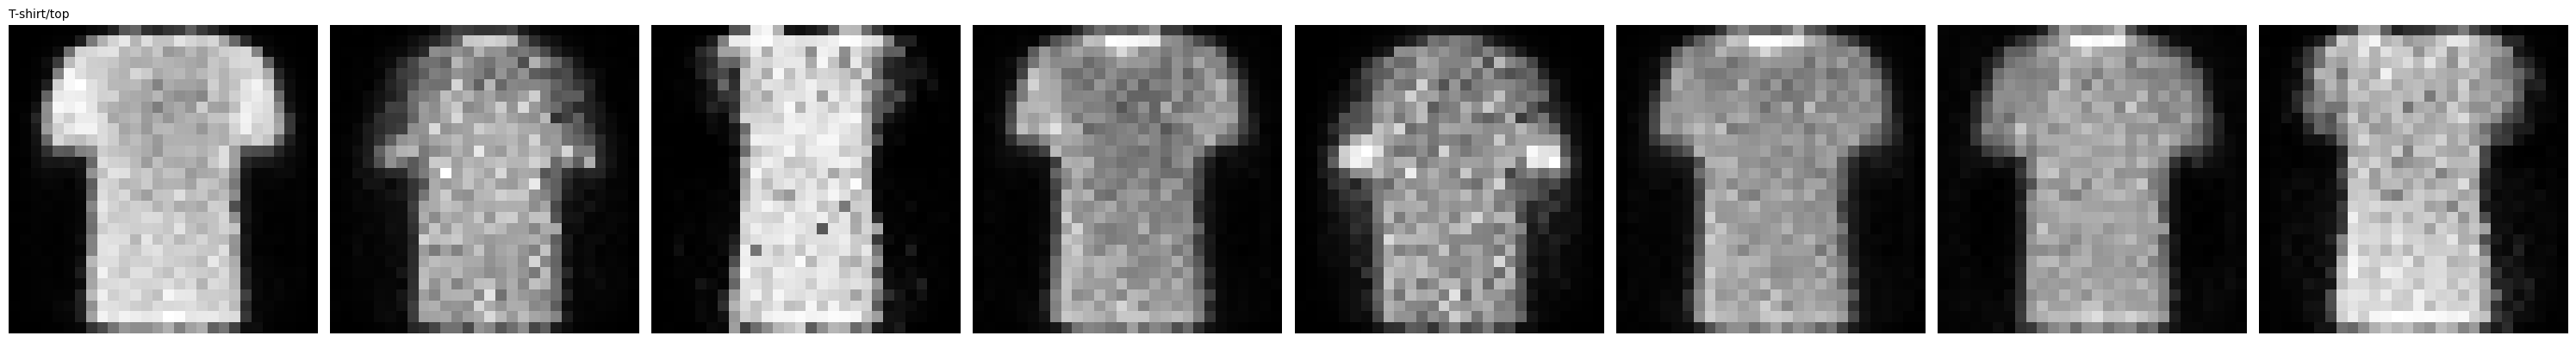

Generate images for Trouser


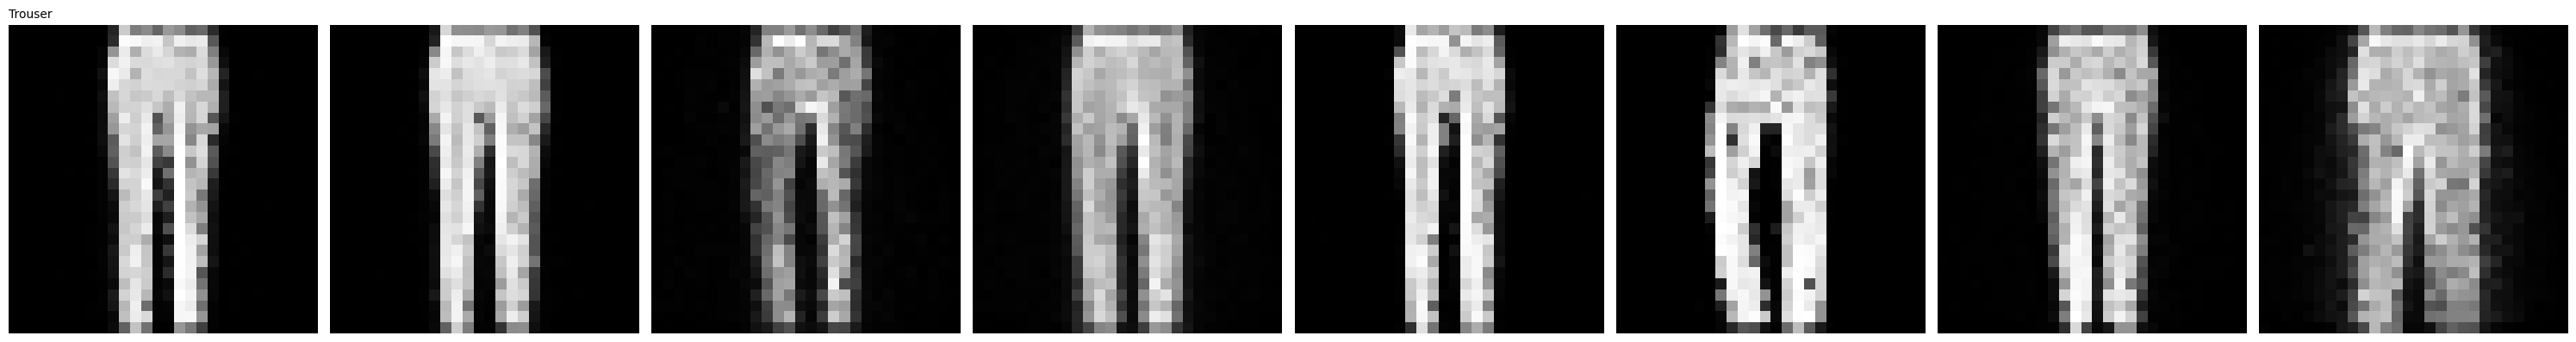

Generate images for Pullover


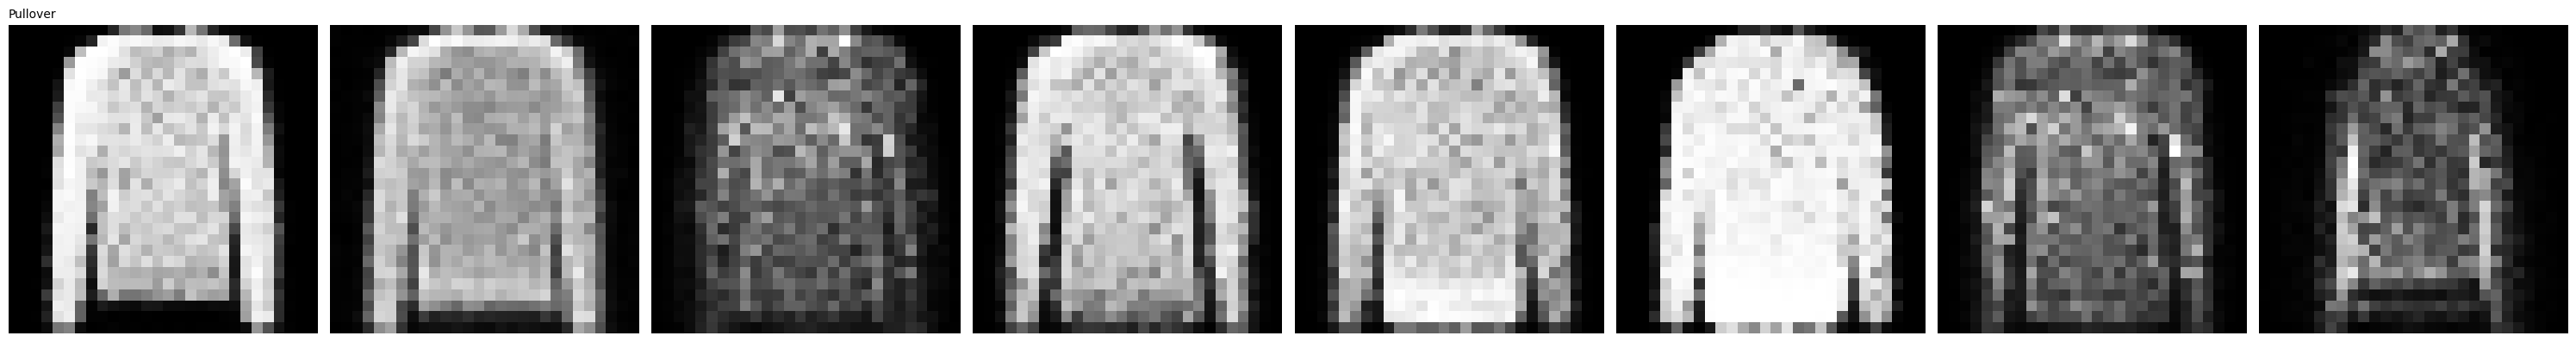

Generate images for Dress


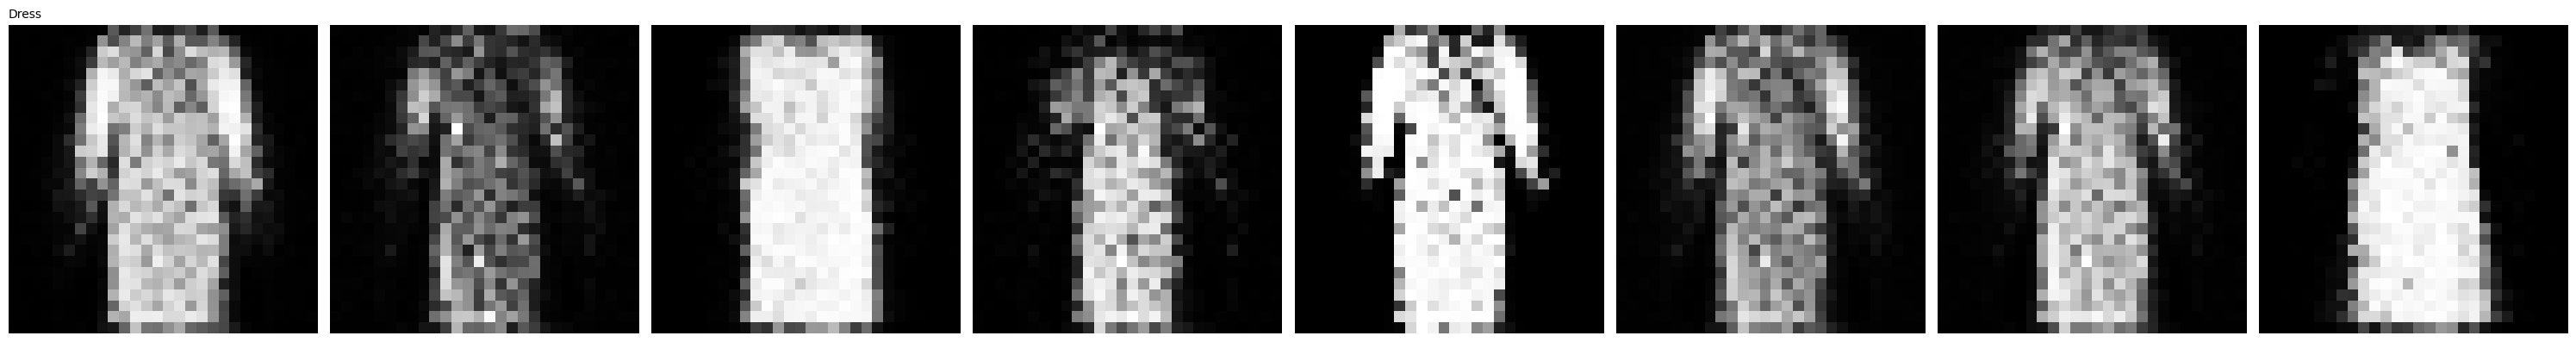

Generate images for Coat


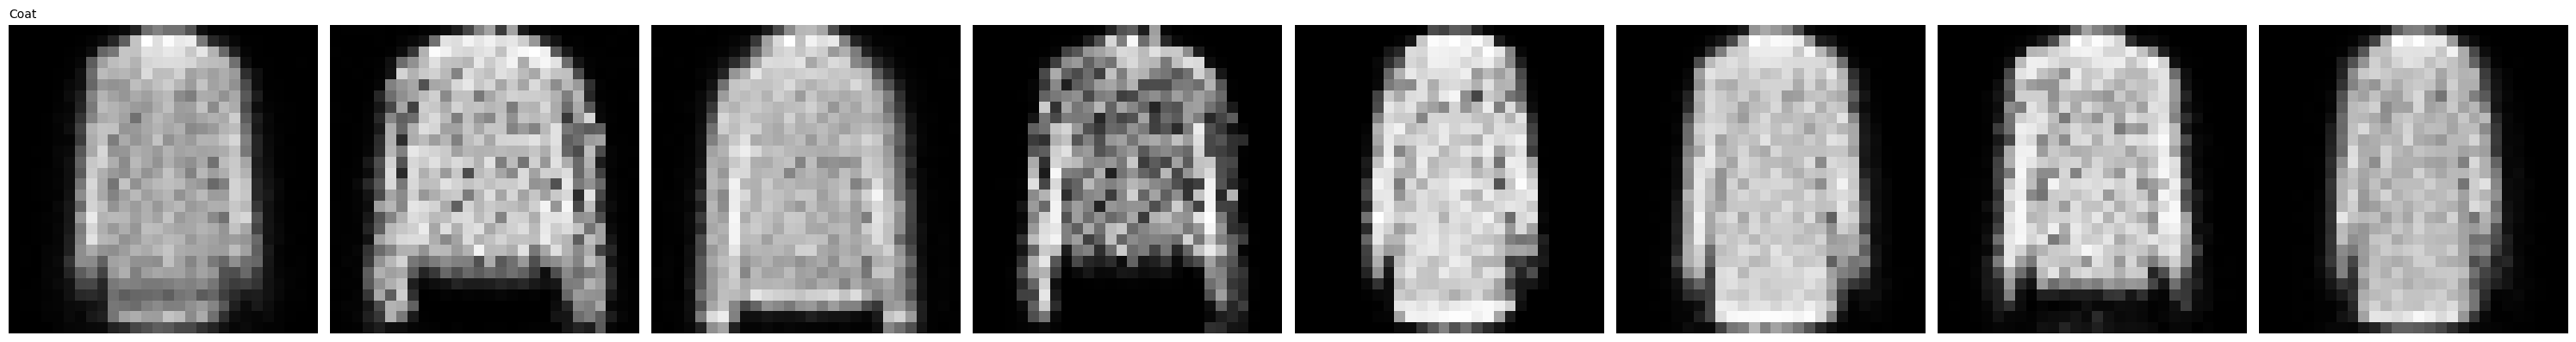

Generate images for Sandal


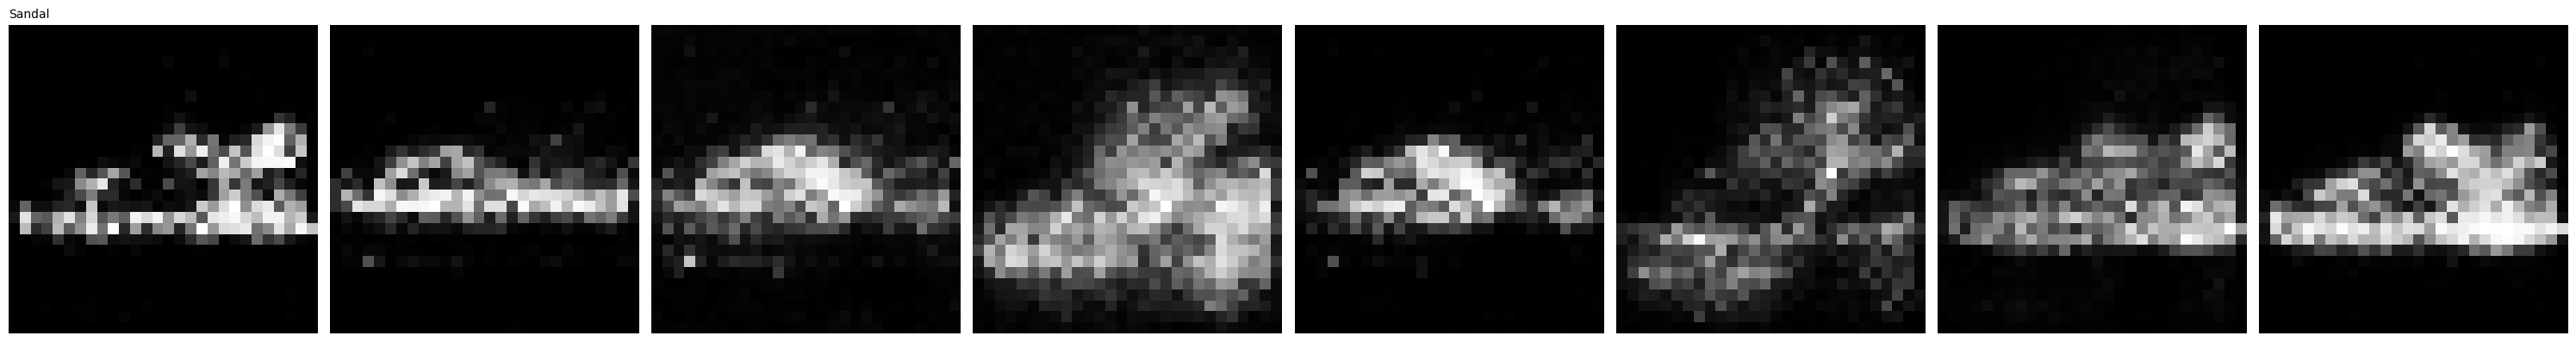

Generate images for Shirt


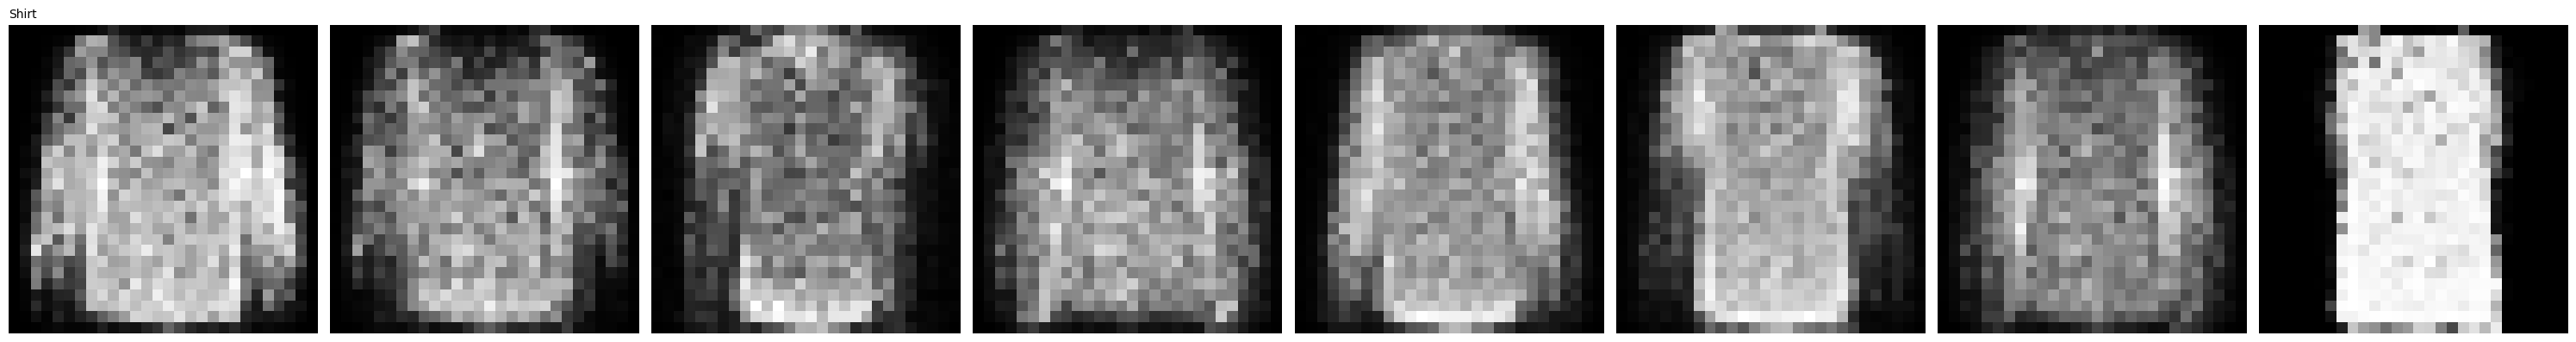

Generate images for Sneaker


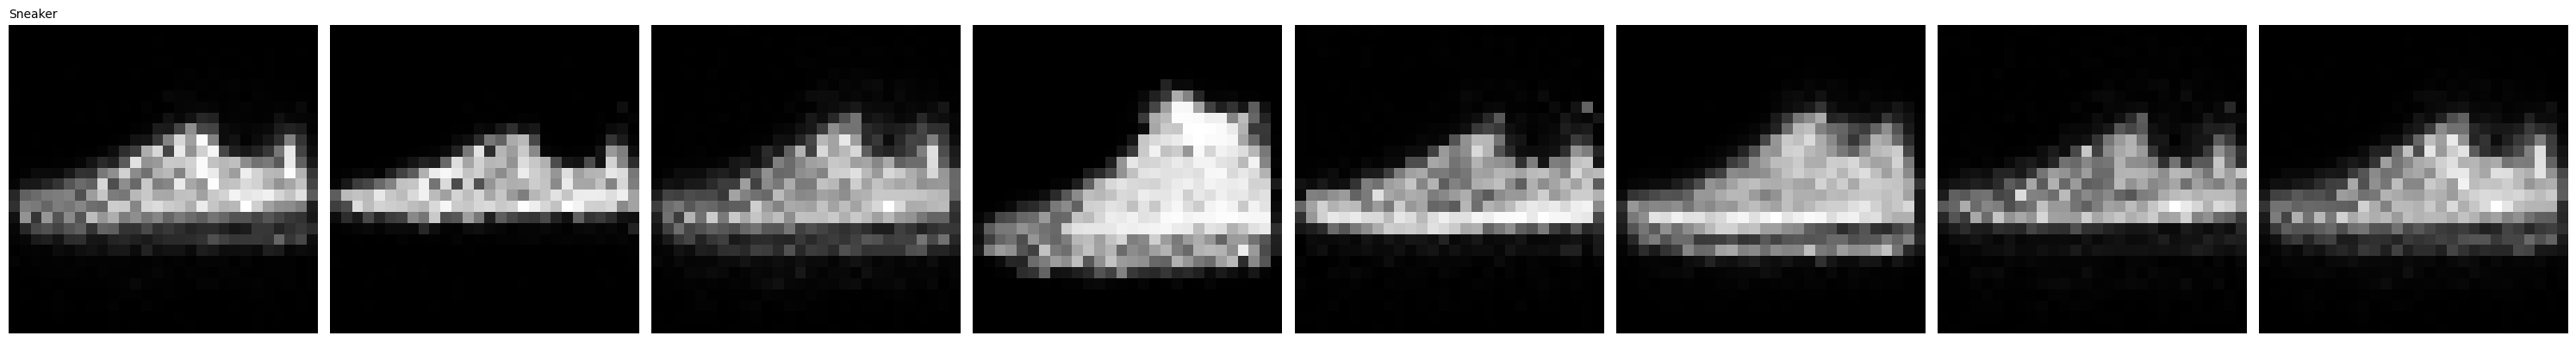

Generate images for Bag


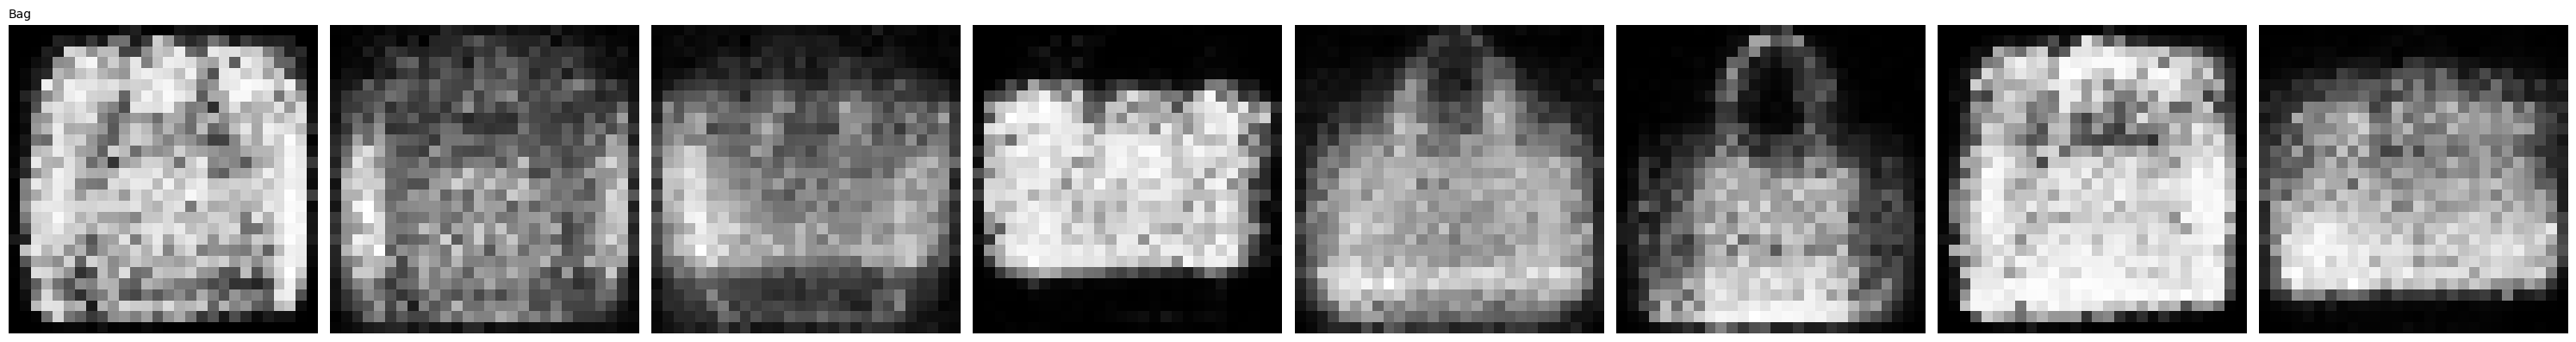

Generate images for Ankle boot


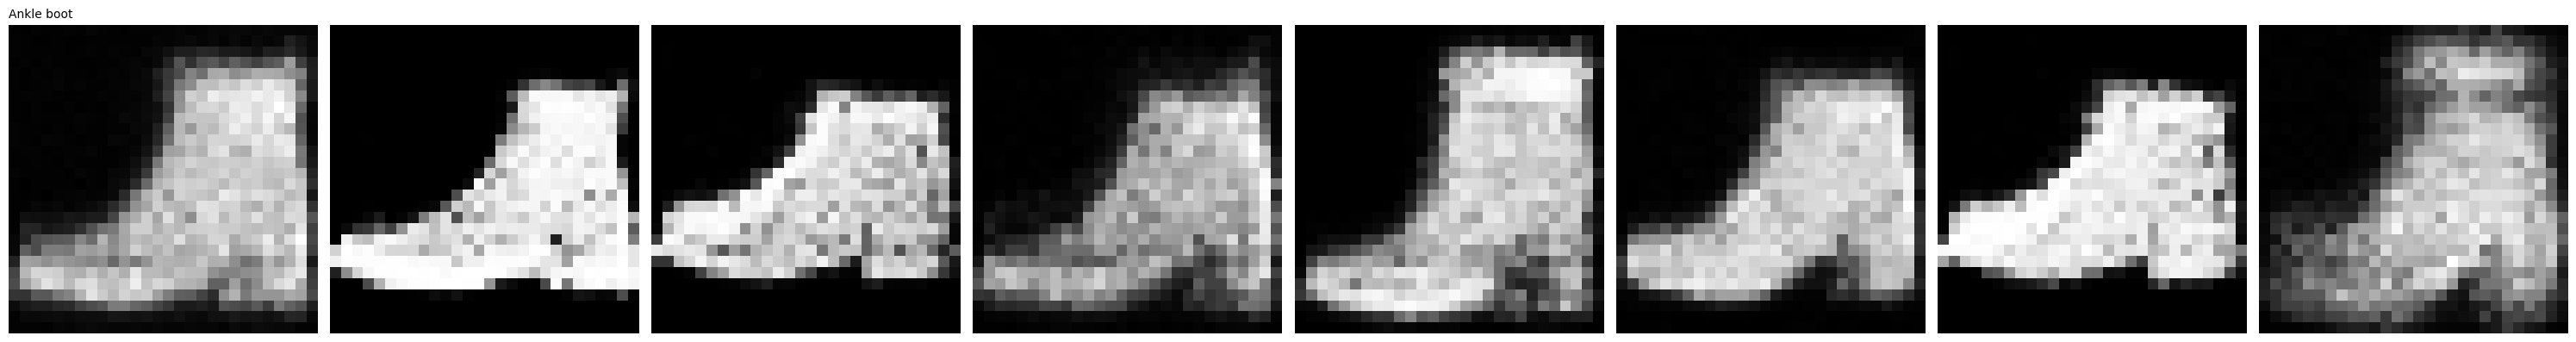

In [125]:
for i in range(10):
    print(f"Generate images for {fashion_mnist_labels[i]}")
    generate_fake_images(label_index=i)

# Round 2

Generate images for T-shirt/top


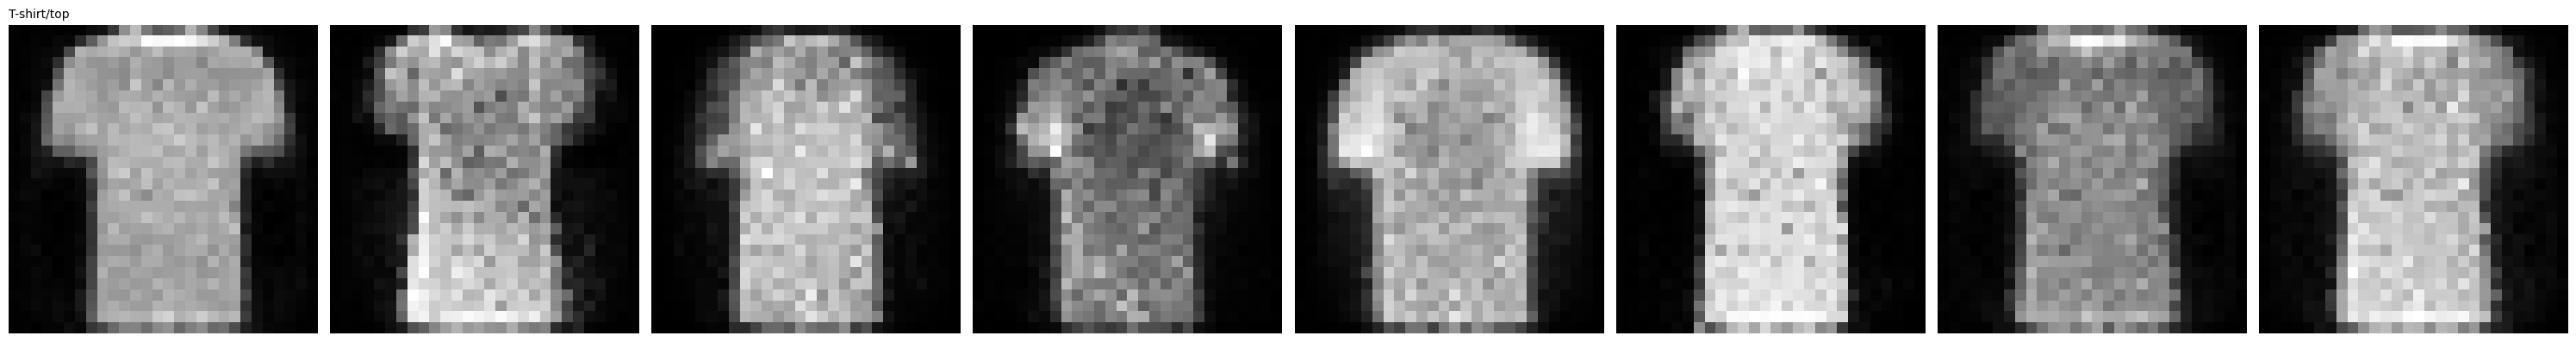

Generate images for Trouser


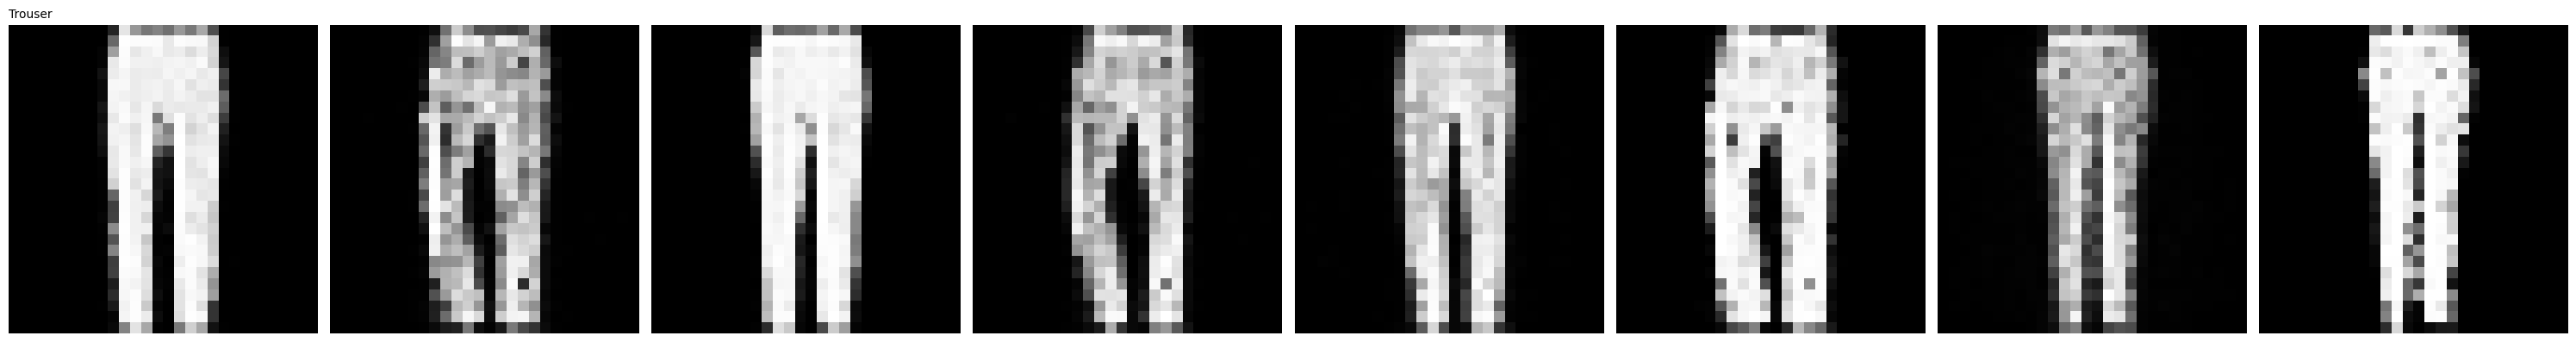

Generate images for Pullover


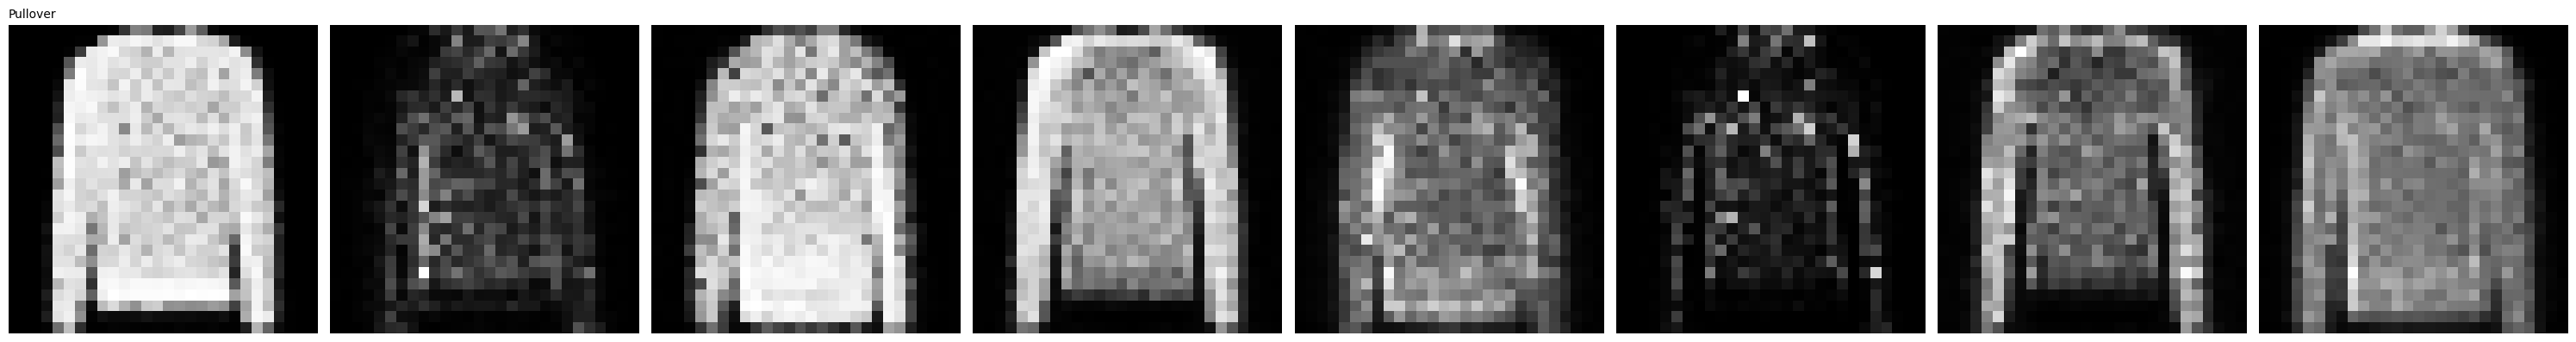

Generate images for Dress


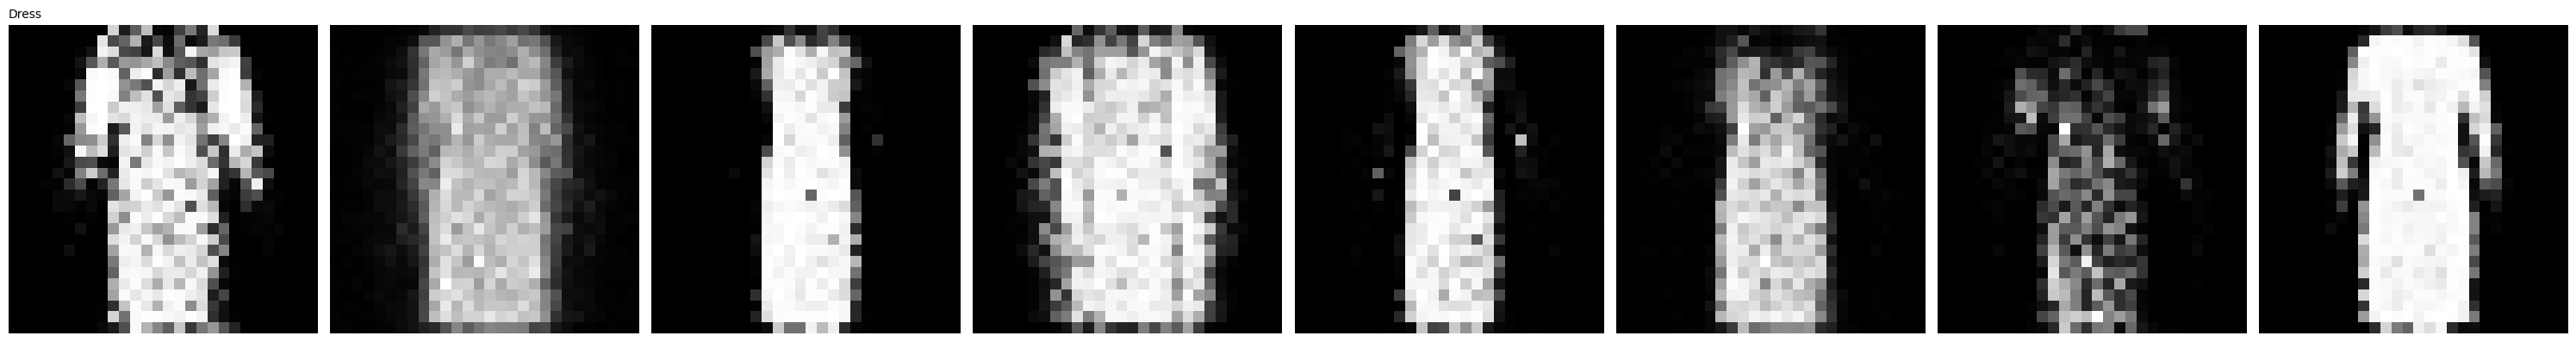

Generate images for Coat


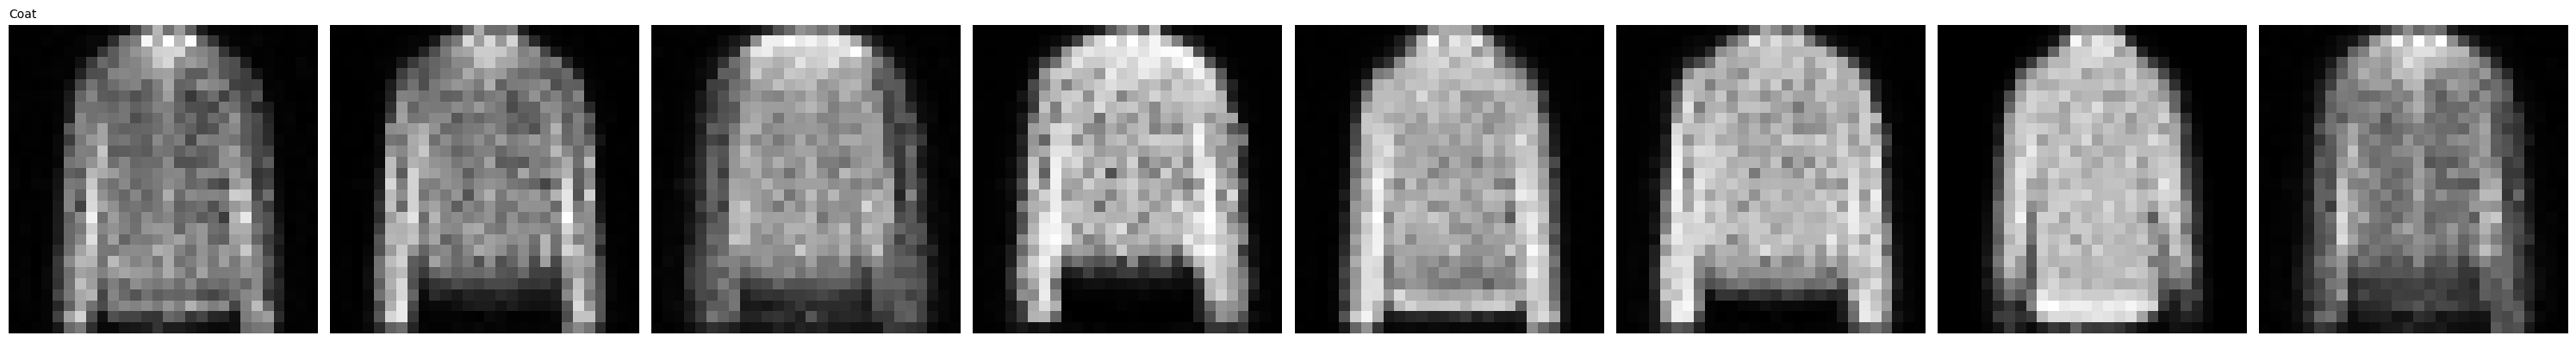

Generate images for Sandal


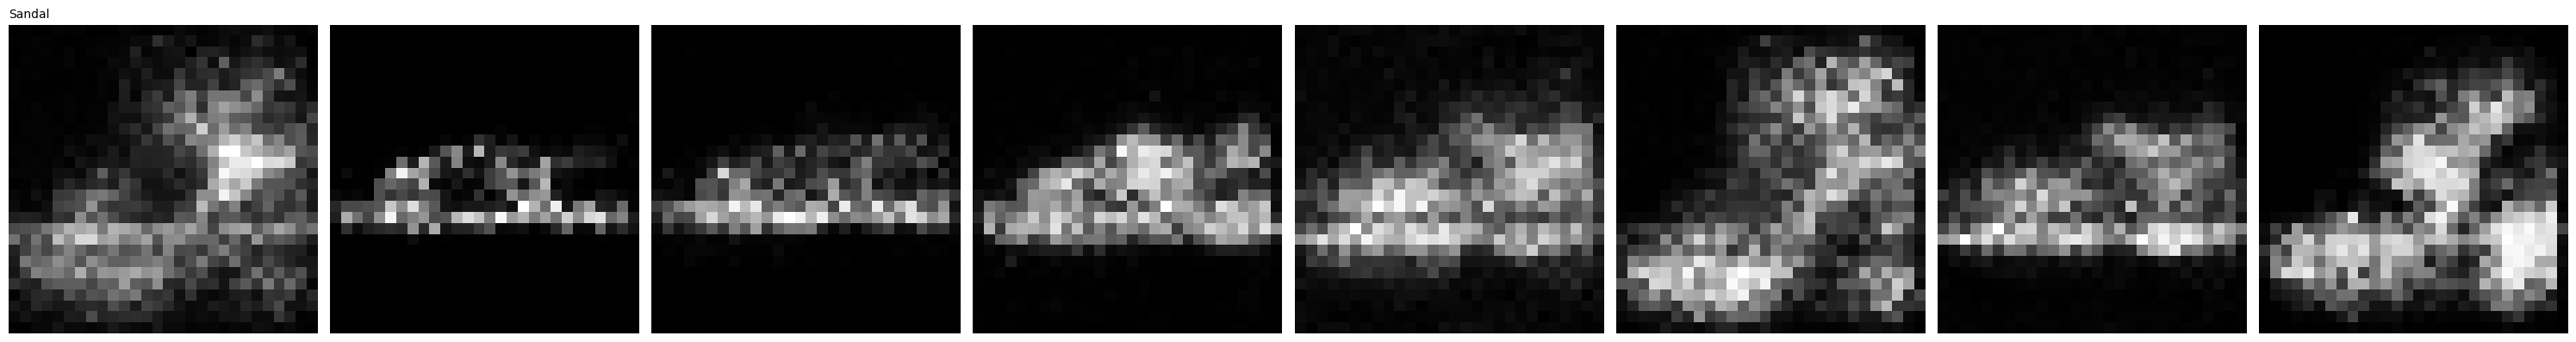

Generate images for Shirt


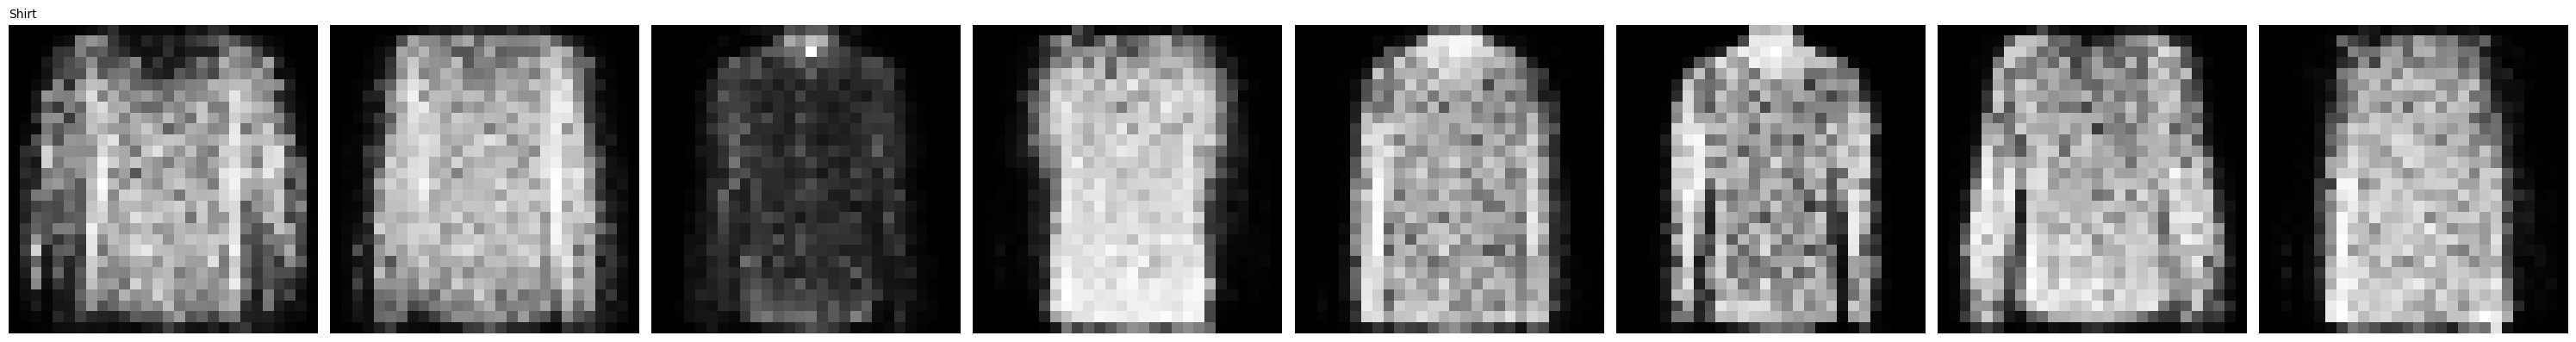

Generate images for Sneaker


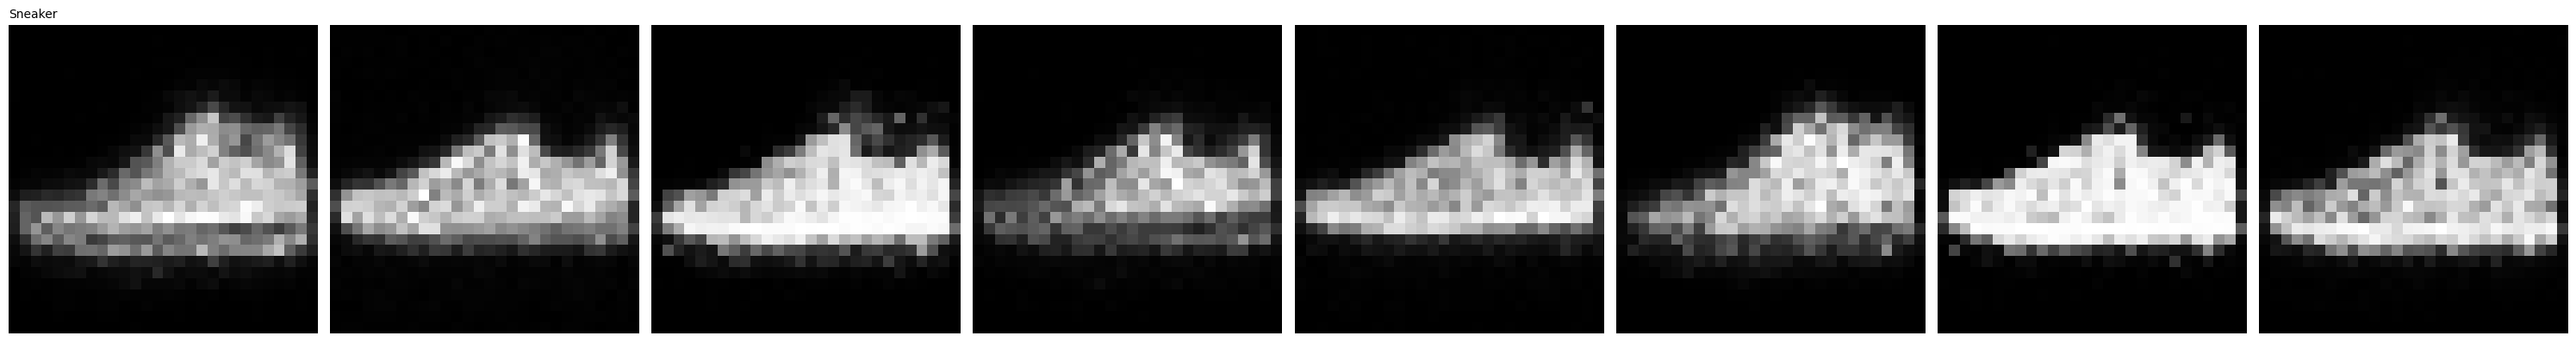

Generate images for Bag


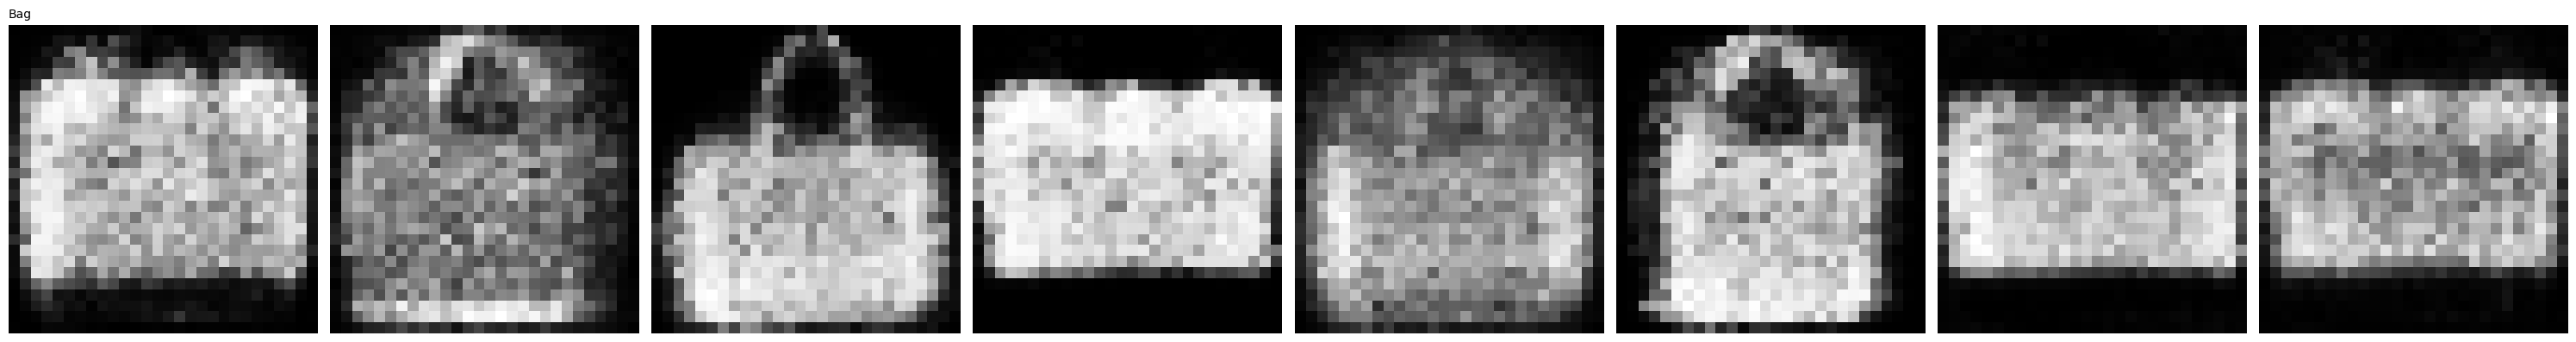

Generate images for Ankle boot


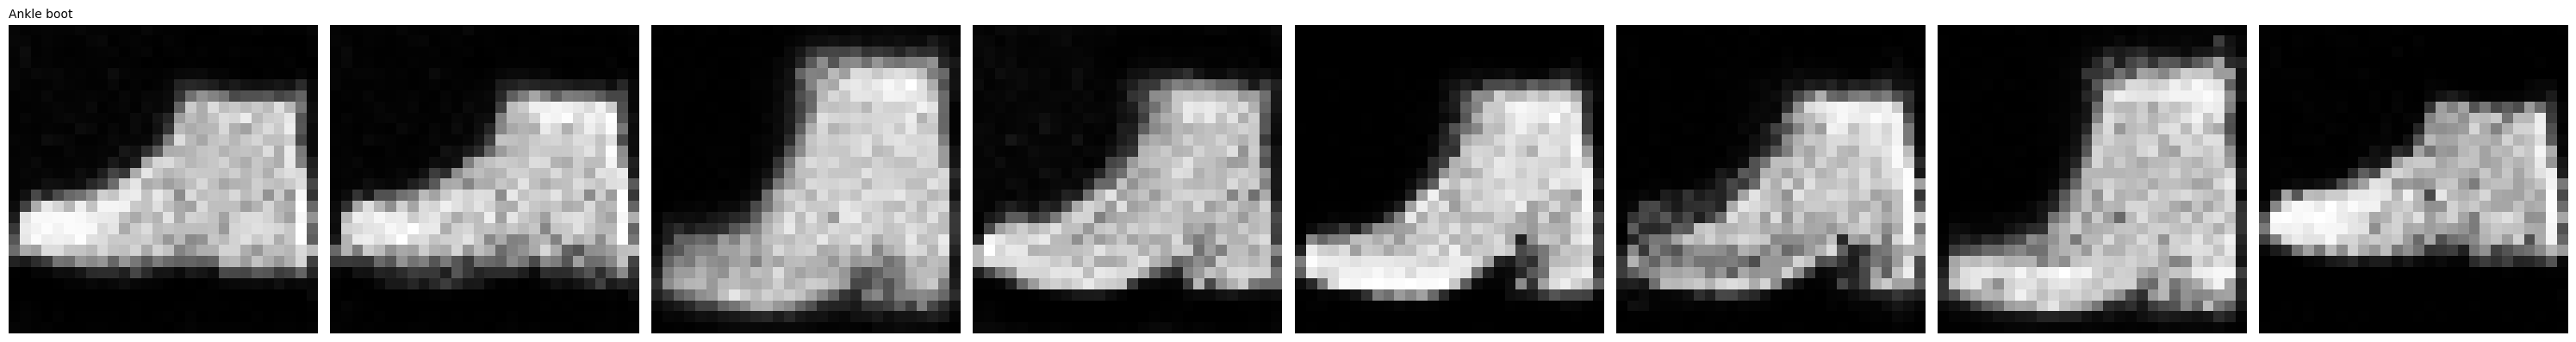

In [127]:
for i in range(10):
    print(f"Generate images for {fashion_mnist_labels[i]}")
    generate_fake_images(label_index=i)

# Conclusion
If we observe the training, we will notice two things.
- `Generator loss` is decreasing.
- `discriminator loss` is increasing.

This is expected:
- initially, the `generator` just outputs `random image`, making it easy for discriminator to distinguish.
- After the `generator` learns, it becomes hard for `discriminator` to distinguish easily, making the `discriminator loss` gradually increasing. 

After 100 epochs of each, the generator has a very good performance:

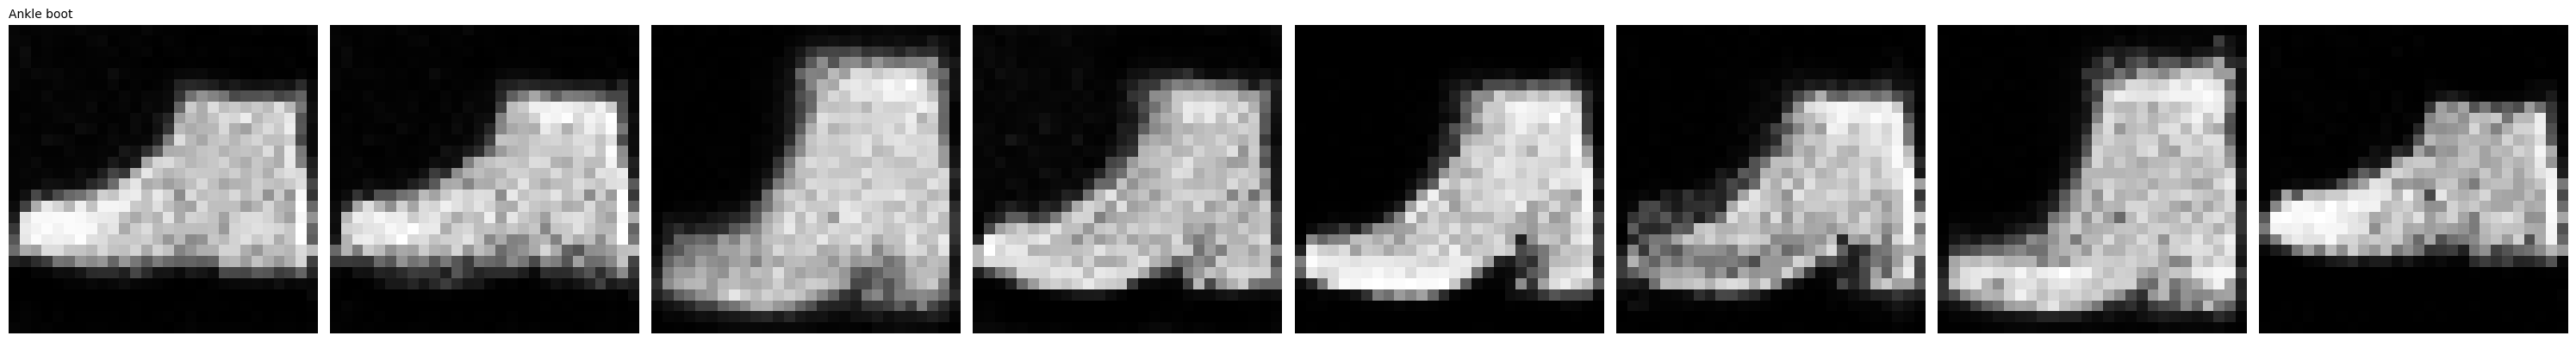